In [ ]:
import functools
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split as _train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

# It gives us insight 

# Import CSV data

In [1153]:
sheet_id = '1eb-NV5o-ed9DgS-tQuG_hL_MHVRaUKB1uT_889Uhg2k'
sheet_name = 'test'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
trips = pd.read_csv(url, parse_dates=['calc_created'])

In [1154]:
trips.head()

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 03:37:31,4.04,10.0,2839,700,1,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 02:26:19,6.09,3.6,5698,493,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 06:34:54,72871.72,NaN,49748,1400,0,client,finished,...,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,...,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN


In [1155]:
cond = trips['metered_price'].notna()
cond &= trips['predicted_distance'] > 0
cond &= trips['predicted_duration'] > 0
trips = trips.loc[cond]

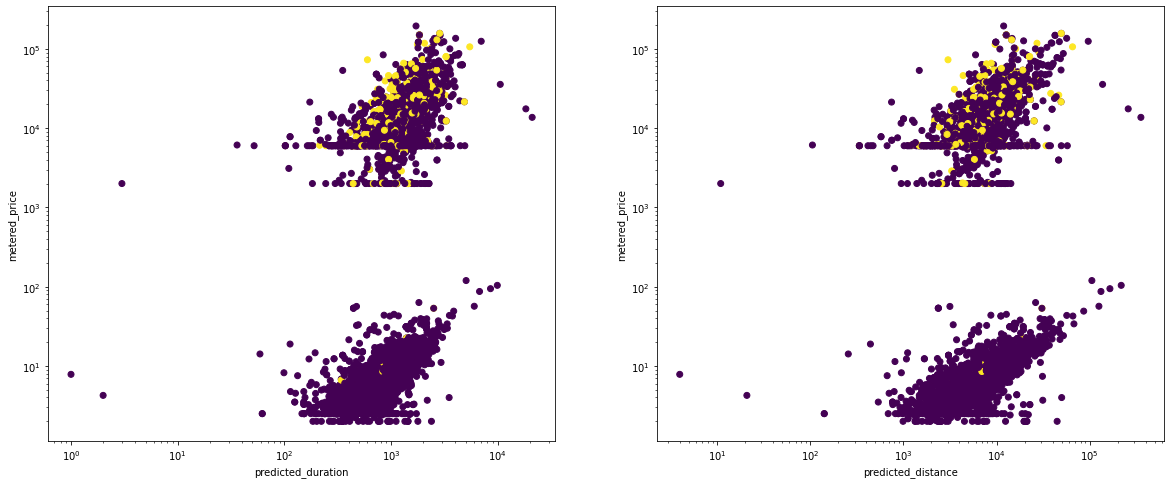

In [1100]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['predicted_duration'], trips['metered_price'], c=trips['overpaid_ride_ticket'])
ax[0].set_xlabel('predicted_duration')
ax[0].set_ylabel('metered_price')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(trips['predicted_distance'], trips['metered_price'], c=trips['overpaid_ride_ticket'])
ax[1].set_xlabel('predicted_distance')
ax[1].set_ylabel('metered_price')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [1156]:
logcols = ['upfront_price', 'metered_price', 
           'predicted_distance', 'predicted_duration', 
           'duration', 'distance']
trips.loc[:, logcols] = np.log(trips.loc[:, logcols])
usecols = logcols + ['calc_created', 'eu_indicator', 
                     'gps_confidence', 'overpaid_ride_ticket', 
                     'dest_change_number', 'prediction_price_type', 
                     'change_reason_pricing']

# select valuable columns
trips = trips.loc[:, usecols]

# add some features
# trips['speed'] = trips['predicted_distance'] / trips['predicted_duration']
trips['dayofweek'] = trips['calc_created'].dt.dayofweek
trips['month'] = trips['calc_created'].dt.month
trips['hourofday'] = trips['calc_created'].dt.hour
trips['isairport_2000'] = (trips['metered_price'] == np.log(2000)) * 1
trips['isairport_6000'] = (trips['metered_price'] == np.log(6000)) * 1
trips['2.5'] = (trips['metered_price'] == np.log(2.5)) * 1
trips['2'] = (trips['metered_price'] == np.log(2)) * 1
trips.loc[:, 'change_reason_pricing'] = trips.loc[:, 'change_reason_pricing'].fillna('NONE')
# trips['dayofweek_hourofday'] = trips['dayofweek'] * trips['hourofday']
trips = pd.get_dummies(trips, columns=['dayofweek', 'month', 
                                       'dest_change_number', 'prediction_price_type', 
                                       'change_reason_pricing'])
trips.drop(columns=['calc_created'], inplace=True)

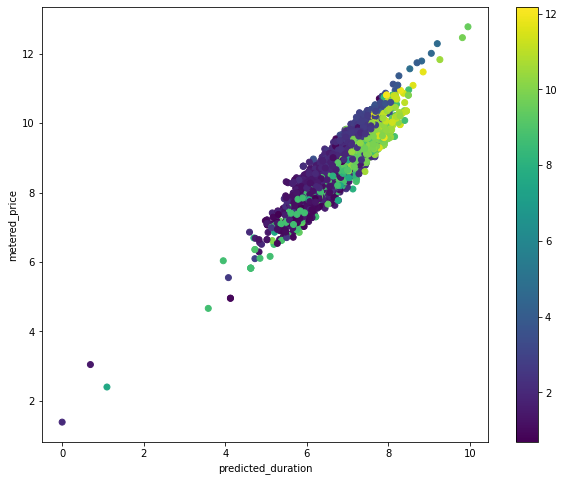

In [1111]:
fig= plt.figure(figsize=(10, 8))
plt.scatter(trips['predicted_duration'], trips['predicted_distance'], c=trips['metered_price'])
plt.xlabel('predicted_duration')
plt.ylabel('metered_price')
# plt.xscale('log')
# plt.yscale('log')
# ax[1].scatter(trips['predicted_distance'], trips['metered_price'], c=trips['gps_confidence'])
# ax[1].set_xlabel('predicted_distance')
# ax[1].set_ylabel('metered_price')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
plt.colorbar()

In [1035]:
# features = trips.drop(columns=['upfront_price', 'duration', 'distance'])
# mask = (features['eu_indicator'] == 1) 
# features = features.loc[mask]
# mu = features['predicted_distance'].mean()
# sigma = features['predicted_distance'].std()
# mask = (features['predicted_distance'] <= mu + 3 * sigma)
# mask &= (mu - 3 * sigma <= features['predicted_distance'])
# mu = features['metered_price'].mean()
# sigma = features['metered_price'].std()
# mask &= (features['metered_price'] <= mu + 3 * sigma)
# mask &= (mu - 3 * sigma <= features['metered_price'])

# labels = features.loc[mask, 'metered_price']
# features = features.loc[mask, ['predicted_distance']]

# X, y = train_test_split(features, labels, random_state=42)

In [1157]:
labels = trips.loc[:, 'metered_price']
features = trips.drop(columns=['metered_price', 'upfront_price', 'duration', 'distance'])

X, y = train_test_split(features, labels, random_state=42)

In [1160]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
]
ridge_pipe = Pipeline(steps)
# ridge_pipe.fit(X['train'], y['train'])
# print_results(ridge_pipe, X['test'], y['test'])

param_grid = {
    'ridge__alpha': [7, 10, 11, 15, 18],
}
grid_search = GridSearchCV(estimator=ridge_pipe, param_grid=param_grid, cv=None, n_jobs=-1, verbose=1)
grid_search.fit(X['train'], y['train'])
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X['test'])
print_results(best_grid, X['test'], y['test'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'ridge__alpha': 15}
R^2 = 0.98784
RMSE = 0.42579
Baseline RMSE = 0.42209


In [1072]:
print_results(best_grid, X['train'], y['train'])

R^2 = 0.52855
RMSE = 0.39820
Baseline RMSE = 0.31353


In [990]:
mean_squared_error(y['train'], bbb)

0.3773572481358277

In [1073]:
aaa = best_grid.predict(X['train'])

In [1074]:
# plt.hist(y['train'] - aaa, density=True, bins=20)

In [1075]:
dd = pd.DataFrame({'metered_price': y['train'], 'linear_regr': aaa, 'bolt_pred': trips['upfront_price'][y['train'].index]})
dd = dd.dropna(subset=['bolt_pred'])
dd

,metered_price,linear_regr,bolt_pred
834,2.075684,2.160034,2.054124
2405,2.599722,1.944344,2.631889
1417,1.000632,1.348386,1.163151
3567,1.504077,1.184001,1.504077
3472,1.057790,1.208708,1.029619
...,...,...,...
2951,1.363537,1.661045,1.386294
2000,2.002830,1.444090,1.808289
2057,1.749200,1.428952,1.410987
2360,3.256557,2.511858,2.714695


In [1076]:
(mean_squared_error(dd['metered_price'], dd['linear_regr']),
mean_squared_error(dd['metered_price'], dd['bolt_pred']))

(0.13339056623188672, 0.09829824901198192)

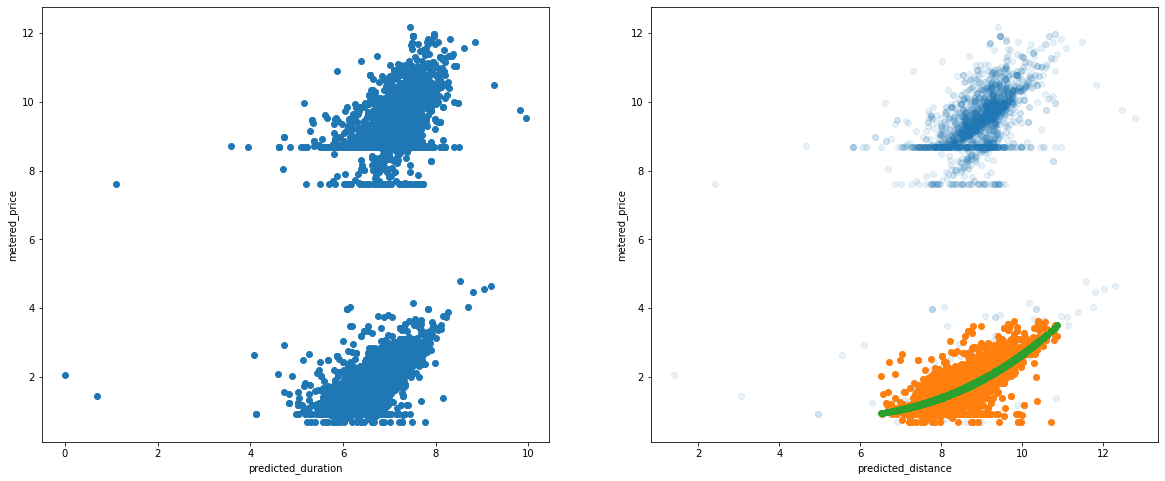

In [1078]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['predicted_duration'], trips['metered_price'])
ax[0].set_xlabel('predicted_duration')
ax[0].set_ylabel('metered_price')
ax[1].scatter(trips['predicted_distance'], trips['metered_price'],  alpha=0.1)
ax[1].scatter(X['train'], y['train'])
ax[1].set_xlabel('predicted_distance')
ax[1].set_ylabel('metered_price')
ax[1].scatter(X['train'], aaa)
# ax[1].scatter(X['train'], trips['upfront_price'][y['train'].index])

In [1062]:
from sklearn.ensemble import IsolationForest 

f = trips.loc[:, ['predicted_distance', 'metered_price']]
isol = IsolationForest(random_state=0).fit(f)
isol.predict(f)

array([-1,  1,  1, ...,  1,  1,  1])

Text(0, 0.5, 'metered_price')

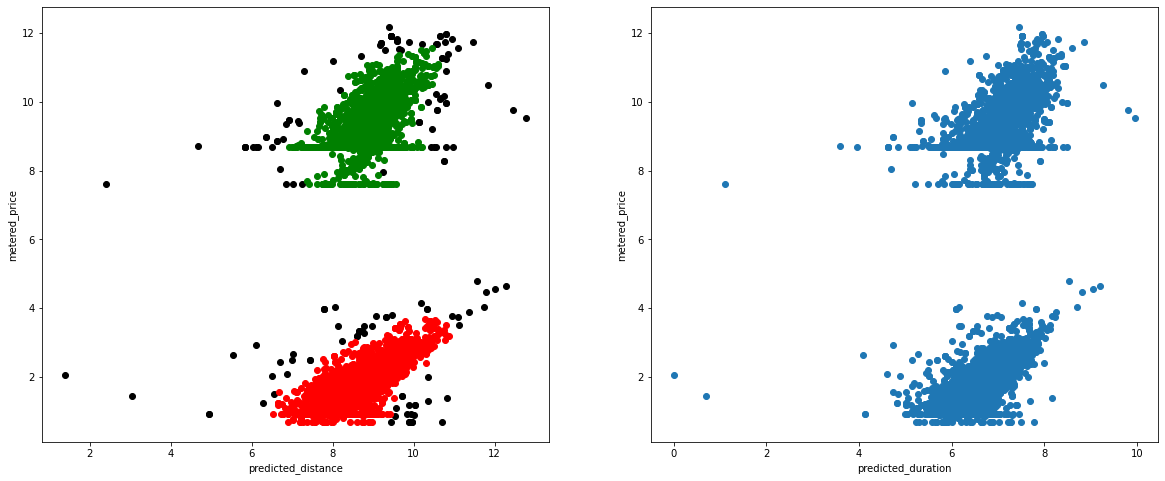

In [1065]:
gm = DBSCAN(0.3, min_samples=15).fit(trips.loc[:, ['predicted_distance', 'metered_price']])

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# m0 = isol.predict(f) == -1
# m1 = isol.predict(f) == 1
m0 = gm.labels_ == -1
m1 = gm.labels_ == 0
m2 = gm.labels_ == 1
m3 = gm.labels_ == 2
ax[0].scatter(trips['predicted_distance'][m0], trips['metered_price'][m0], c='k')
ax[0].scatter(trips['predicted_distance'][m1], trips['metered_price'][m1], c='r')
ax[0].scatter(trips['predicted_distance'][m2], trips['metered_price'][m2], c='g')
ax[0].scatter(trips['predicted_distance'][m3], trips['metered_price'][m3], c='b')
ax[0].set_xlabel('predicted_distance')
ax[0].set_ylabel('metered_price')
ax[1].scatter(trips['predicted_duration'], trips['metered_price'])
ax[1].set_xlabel('predicted_duration')
ax[1].set_ylabel('metered_price')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['predicted_duration'], trips['metered_price'])
# ax[0].set_xlim([0, 5000])
# ax[0].set_ylim([0, 125000])
ax[0].set_xlabel('duration')
ax[0].set_ylabel('metered_price')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(trips['predicted_distance'], trips['metered_price'])
# ax[1].set_xlim([0, 50000])
# ax[1].set_ylim([0, 100000])
ax[1].set_xlabel('distance')
ax[1].set_ylabel('metered_price')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [717]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestCentroid 

f = trips[['metered_price', 'predicted_distance']]
# f = StandardScaler().fit_transform(trips[['metered_price', 'predicted_distance']])
# f = pd.DataFrame(f, columns=['metered_price', 'predicted_distance'])
f = f.loc[~f['metered_price'].isin([2000, 6000])]
f = f.loc[f['metered_price']>=2000]
init = np.array([[f['metered_price'][f['metered_price'] > 1e3].mean(), 
                  f['predicted_distance'][f['metered_price'] > 1e3].mean()], 
                 [f['metered_price'][f['metered_price'] < 1e3].mean(), 
                  f['predicted_distance'][f['metered_price'] < 1e3].mean()]])
gm = GaussianMixture(n_components=2, random_state=0).fit(f)
gm = DBSCAN(0.4).fit(np.log(f))
# gm = KMeans(2, init=init).fit(f)
# gm = NearestCentroid().fit(f, (f['metered_price']>=2000) * 1)

gm.predict(f)
# gm.labels_

array([1, 0, 0, ..., 0, 0, 0])

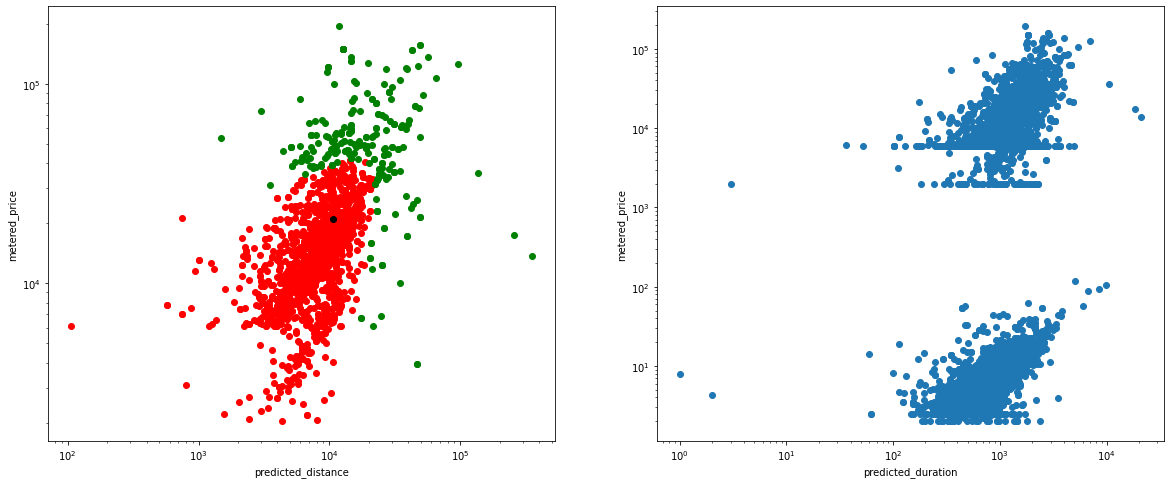

In [719]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
m1 = gm.predict(f) == 0
m2 = gm.predict(f) == 1
m3 = gm.predict(f) == 2
# m0 = gm.labels_ == -1
# m1 = gm.labels_ == 0
# m2 = gm.labels_ == 1
# m3 = gm.labels_ == 2
# ax[0].scatter(f['predicted_distance'][m0], f['metered_price'][m0], c='k')
ax[0].scatter(f['predicted_distance'][m1], f['metered_price'][m1], c='r')
ax[0].scatter(f['predicted_distance'][m2], f['metered_price'][m2], c='g')
ax[0].scatter(f['predicted_distance'][m3], f['metered_price'][m3], c='b')
ax[0].scatter(init[0][1], init[0][0], c='k')
ax[0].scatter(init[1][1], init[1][0], c='k')
# ax[0].set_xlim([0, 5000])
# ax[0].set_ylim([0, 125000])
ax[0].set_xlabel('predicted_distance')
ax[0].set_ylabel('metered_price')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(trips['predicted_duration'], trips['metered_price'])
# ax[1].set_xlim([0, 50000])
# ax[1].set_ylim([0, 100000])
ax[1].set_xlabel('predicted_duration')
ax[1].set_ylabel('metered_price')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

KeyError: 'overpaid_ride_ticket'

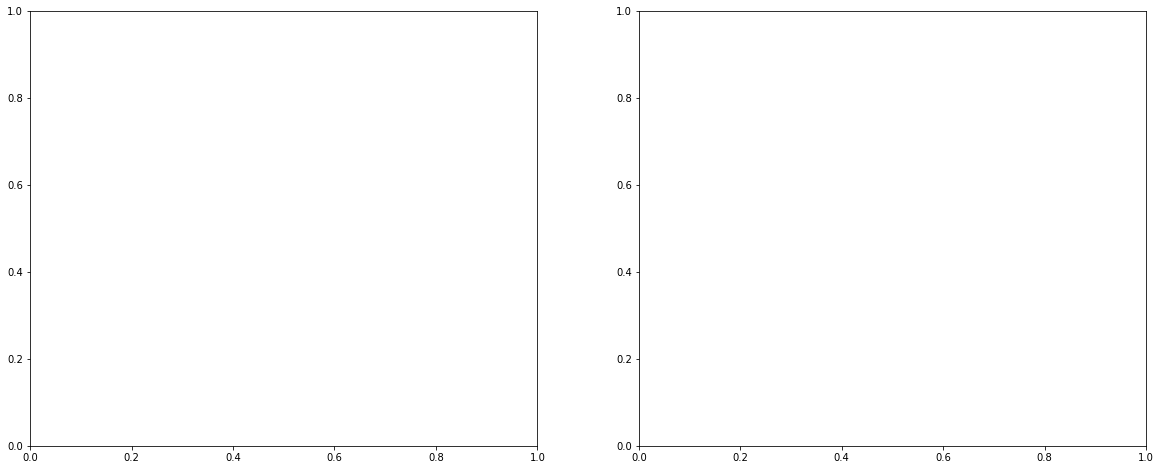

In [1066]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['duration'], trips['metered_price'], c=trips['overpaid_ride_ticket'])
# ax[0].set_xlim([0, 5000])
# ax[0].set_ylim([0, 125000])
ax[0].set_xlabel('duration')
ax[0].set_ylabel('metered_price')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(trips['distance'], trips['metered_price'], c=trips['overpaid_ride_ticket'])
# ax[1].plot(np.linspace(100, 10000), np.linspace(100, 10000) * 0.83)
# ax[1].set_xlim([0, 50000])
# ax[1].set_ylim([0, 100000])
ax[1].set_xlabel('distance')
ax[1].set_ylabel('metered_price')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

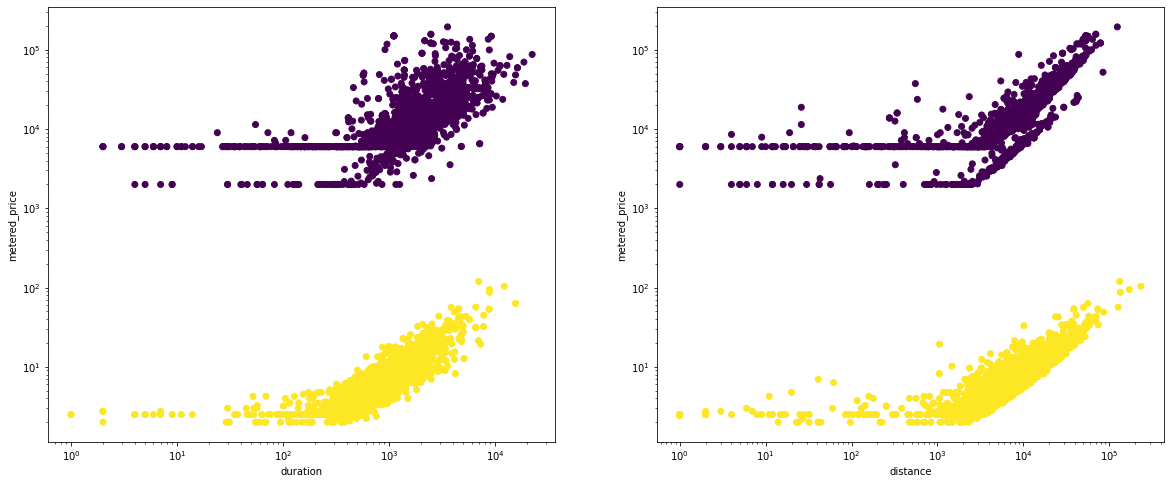

In [770]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['duration'], trips['metered_price'], c=trips['eu_indicator'])
# ax[0].set_xlim([0, 5000])
# ax[0].set_ylim([0, 125000])
ax[0].set_xlabel('duration')
ax[0].set_ylabel('metered_price')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(trips['distance'], trips['metered_price'], c=trips['eu_indicator'])
# ax[1].plot(np.linspace(100, 10000), np.linspace(100, 10000) * 0.83)
# ax[1].set_xlim([0, 50000])
# ax[1].set_ylim([0, 100000])
ax[1].set_xlabel('distance')
ax[1].set_ylabel('metered_price')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

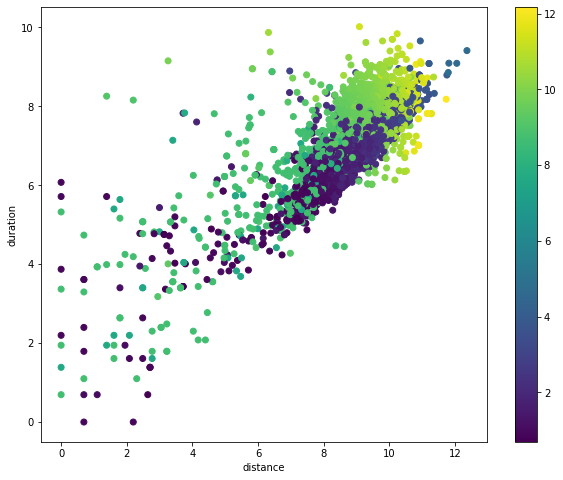

In [744]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(trips['distance'], trips['duration'], c=trips['metered_price'], cmap='viridis')
plt.xlabel('distance')
plt.ylabel('duration')
plt.colorbar()
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(right=20000)
# plt.ylim(top=4000)

# Clean up the data + feature engineering 

In [741]:
cond = trips['metered_price'].notna()
cond &= trips['predicted_distance'] > 0
cond &= trips['predicted_duration'] > 0
trips = trips.loc[cond]

usecols = ['metered_price', 'predicted_distance', 'predicted_duration', 'duration', 'distance']
trips.loc[:, usecols] = np.log(trips.loc[:, usecols])

In [743]:
usecols = ['upfront_price', 'metered_price', 
           'predicted_duration', 'predicted_distance', 
           'calc_created', 'duration', 'distance']

# select valuable columns
trips = trips.loc[:, usecols]

# add some features
# trips['speed'] = trips['predicted_distance'] / trips['predicted_duration']
trips['dayofweek'] = trips['calc_created'].dt.dayofweek
trips['month'] = trips['calc_created'].dt.month
trips['hourofday'] = trips['calc_created'].dt.hour
trips['isairport_2000'] = trips['metered_price'] == np.log(2000)
trips['isairport_6000'] = trips['metered_price'] == np.log(6000)
trips['insidecity'] = trips['metered_price'] < np.log(2000)
trips['outsidecity'] = (
    (trips['metered_price'] >= np.log(2000)) 
    & (~trips['metered_price'].isin([np.log(2000), np.log(6000)]))
)
# trips['dayofweek_hourofday'] = trips['dayofweek'] * trips['hourofday']
trips = pd.get_dummies(trips, columns=['dayofweek', 'month'])
trips.drop(columns=['calc_created'], inplace=True)

In [731]:
trips.head()

,upfront_price,metered_price,predicted_duration,predicted_distance,hourofday,isairport_2000,isairport_6000,insidecity,outsidecity,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,month_2,month_3
0,10.0,1.396245,6.994850,9.501815,3,False,False,True,False,0,0,0,0,0,0,1,1,0
1,3.6,1.806648,5.886104,7.734559,2,False,False,True,False,0,0,0,0,0,1,0,1,0
2,3.5,1.463255,6.070738,8.318986,11,False,False,True,False,0,0,0,0,0,1,0,1,0
3,NaN,11.196456,6.396930,8.012018,6,False,False,False,True,0,0,1,0,0,0,0,1,0
4,19500.0,9.905111,7.929487,9.563529,17,False,False,False,True,0,0,0,1,0,0,0,1,0


# Analysis

<AxesSubplot:>

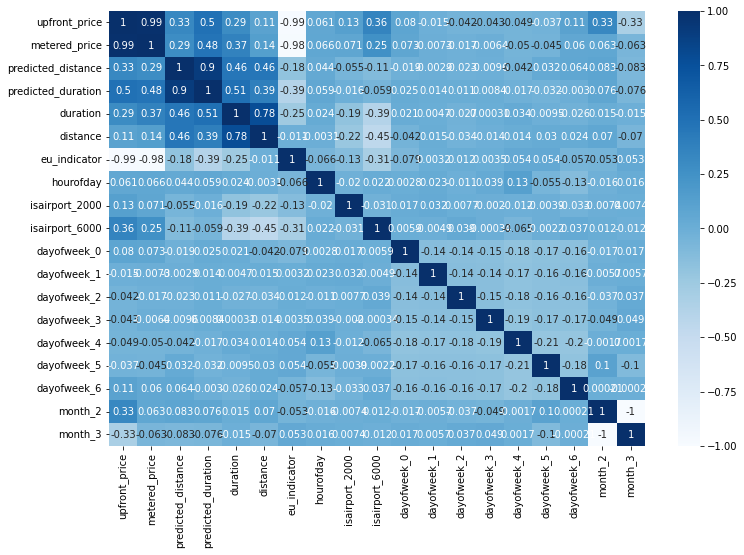

In [784]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(trips.corr(), cmap='Blues', annot=True, ax=ax)

## Linear models

In [785]:
def rmse_decorator(func):
    @functools.wraps(func)
    def wrapper_rmse(*args, **kwargs):
        if len(args) == 3:
            return make_scorer(func)(*args, **kwargs) 
        else:
            return func(*args, **kwargs)
    
    return wrapper_rmse


@rmse_decorator
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)
#     cond = np.abs(y_true - y_pred) / y_pred * 100 > 20
#     return np.where(cond, y_true, y_pred).sum()

In [786]:
def train_test_split(features, labels, train_size=.8, test_size=.2, **params):
    X, y = {}, {}
    
    X['train'], X['test'], y['train'], y['test'] = _train_test_split(
        features, 
        labels, 
        test_size=test_size, 
        train_size=train_size, 
        **params
    )
    
    return X, y
    
def train_valid_test_split(features, labels, train_size=.6, test_size=.2, valid_size=.2, **params):
    X, y = {}, {}
    
    X_train_valid, X['test'], y_train_valid, y['test'] = _train_test_split(
        features, 
        labels, 
        test_size=test_size, 
        train_size=train_size + valid_size,
        **params
    )
    X['train'], X['valid'], y['train'], y['valid'] = _train_test_split(
        X_train_valid, 
        y_train_valid, 
        test_size=valid_size, 
        train_size=train_size + test_size, 
        **params
    )
        
    return X, y

In [787]:
# def print_results(estimator, X_test, y_test):
#     print('R^2 = {:.5f}'.format(estimator.score(X_test, y_test)))
#     print('Revenue = {:.5f}'.format(revenue(estimator, X_test, y_test)))
#     print('Baseline revenue = {:.5f}'.format(revenue(y_test, df['upfront_price'][y_test.index])))

def print_results(estimator, X_test, y_test):
    print('R^2 = {:.5f}'.format(estimator.score(X_test, y_test)))
    print('RMSE = {:.5f}'.format(rmse(estimator, X_test, y_test)))
    upfront_price = trips['upfront_price'][y_test.index]
    mask = upfront_price.notna()
    print('Baseline RMSE = {:.5f}'.format(rmse(y_test.loc[mask], upfront_price.loc[mask])))

In [289]:
# def add_poly_features(X, **params):
#     poly = PolynomialFeatures(**params)
#     X_poly = poly.fit_transform(X)
#     polynomial_column_names=poly.get_feature_names_out(input_features=X.columns)
#     X_poly = pd.DataFrame(data=X_poly, columns=polynomial_column_names)
# #     X_train_poly.columns = X_train_poly.columns.str.replace(' ', '_')
# #     X_train_poly.columns = X_train_poly.columns.str.replace('^', '_')
    
#     return X_poly

In [815]:
features = trips.drop(columns=['metered_price', 'upfront_price', 'duration', 'distance'])
labels = trips['metered_price']

X, y = train_test_split(features, labels, random_state=42)

In [826]:
steps = [
    ('poly', PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
]
ridge_pipe = Pipeline(steps)
# ridge_pipe.fit(X['train'], y['train'])
# print_results(ridge_pipe, X['test'], y['test'])

param_grid = {
    'ridge__alpha': [1, 4, 7, 30, 40],
}
grid_search = GridSearchCV(estimator=ridge_pipe, param_grid=param_grid, cv=None, n_jobs=-1, verbose=1)
grid_search.fit(X['train'], y['train'])
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X['test'])
print_results(best_grid, X['test'], y['test'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'ridge__alpha': 30}
R^2 = 0.98622
RMSE = 0.45337
Baseline RMSE = 0.42209


## Random Forest

In [1161]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('rf', lgb.LGBMRegressor('rf', subsample=0.6, subsample_freq=1))
]
rf_pipe = Pipeline(steps)
# rf_pipe.fit(X['train'], y['train'])
# print_results(rf_pipe, X['test'], y['test'])

param_grid = {
#     'rf__bootstrap': [True],
    'rf__max_depth': [60, 70, 80, 90],
    'rf__n_estimators': [100, 200, 300, 1000]
}
grid_search = GridSearchCV(estimator=rf_pipe, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X['train'], y['train'])
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X['test'])
print_results(best_grid, X['test'], y['test'])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'rf__max_depth': 60, 'rf__n_estimators': 200}
R^2 = 0.98647
RMSE = 0.44914
Baseline RMSE = 0.42209


## LGBM

In [1162]:
# features = trips.drop(columns=['metered_price', 'upfront_price', 'duration', 'distance'])
# labels = trips['metered_price']

X, y = train_valid_test_split(features, labels, random_state=42)

In [1163]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
#     ('lgb', lgb.LGBMRegressor(random_state=42))
]
lgb_pipe = Pipeline(steps)
# rf_pipe.fit(X['train'], y['train'])
# print_results(rf_pipe, X['test'], y['test'])

param_grid = {
    'max_depth': [1, 5, 10, 20, 30],
    'n_estimators': [50, 70, 80, 100],
    'early_stopping_rounds': [20]
}


# lightgbm.early_stopping(stopping_rounds
grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)
grid_search.fit(lgb_pipe.fit_transform(X['train']), y['train'], 
                eval_set=[(lgb_pipe.transform(X['valid']), y['valid'])], 
                eval_metric='rmse')
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(lgb_pipe.transform(X['test']))
print_results(best_grid, lgb_pipe.transform(X['test']), y['test'])

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.52298	valid_0's l2: 12.4114
[2]	valid_0's rmse: 3.19145	valid_0's l2: 10.1853
[3]	valid_0's rmse: 2.8946	valid_0's l2: 8.37872
[4]	valid_0's rmse: 2.6291	valid_0's l2: 6.91219
[5]	valid_0's rmse: 2.39196	valid_0's l2: 5.72146
[6]	valid_0's rmse: 2.18046	valid_0's l2: 4.75439
[7]	valid_0's rmse: 1.99217	valid_0's l2: 3.96876
[8]	valid_0's rmse: 1.82491	valid_0's l2: 3.33031
[9]	valid_0's rmse: 1.67669	valid_0's l2: 2.8113
[10]	valid_0's rmse: 1.54571	valid_0's l2: 2.38922
[11]	valid_0's rmse: 1.43032	valid_0's l2: 2.04581
[12]	valid_0's rmse: 1.32902	valid_0's l2: 1.76629
[13]	valid_0's rmse: 1.24042	valid_0's l2: 1.53865
[14]	valid_0's rmse: 1.16325	valid_0's l2: 1.35315
[15]	valid_0's rmse: 1.09631	valid_0's l2: 1.2019
[16]	valid_0's rmse: 1.03851	valid_0's l2: 1.0785
[

[1]	valid_0's rmse: 3.5231	valid_0's l2: 12.4122
[2]	valid_0's rmse: 3.19137	valid_0's l2: 10.1848
[3]	valid_0's rmse: 2.89434	valid_0's l2: 8.37722
[4]	valid_0's rmse: 2.62869	valid_0's l2: 6.90999
[5]	valid_0's rmse: 2.3914	valid_0's l2: 5.71877
[6]	valid_0's rmse: 2.17977	valid_0's l2: 4.7514
[7]	valid_0's rmse: 1.99138	valid_0's l2: 3.9656
[8]	valid_0's rmse: 1.82403	valid_0's l2: 3.32709
[9]	valid_0's rmse: 1.67573	valid_0's l2: 2.80808
[10]	valid_0's rmse: 1.54469	valid_0's l2: 2.38606
[11]	valid_0's rmse: 1.42925	valid_0's l2: 2.04276
[12]	valid_0's rmse: 1.32792	valid_0's l2: 1.76336
[13]	valid_0's rmse: 1.2393	valid_0's l2: 1.53586
[14]	valid_0's rmse: 1.16212	valid_0's l2: 1.35052
[15]	valid_0's rmse: 1.09518	valid_0's l2: 1.19943
[16]	valid_0's rmse: 1.03739	valid_0's l2: 1.07618
[17]	valid_0's rmse: 0.987708	valid_0's l2: 0.975568
[18]	valid_0's rmse: 0.945183	valid_0's l2: 0.893372
[19]	valid_0's rmse: 0.909564	valid_0's l2: 0.827306
[20]	valid_0's rmse: 0.879027	valid_0's

[1]	valid_0's rmse: 3.52303	valid_0's l2: 12.4118
[2]	valid_0's rmse: 3.19128	valid_0's l2: 10.1843
[3]	valid_0's rmse: 2.89424	valid_0's l2: 8.37663
[4]	valid_0's rmse: 2.62857	valid_0's l2: 6.90939
[5]	valid_0's rmse: 2.39127	valid_0's l2: 5.71818
[6]	valid_0's rmse: 2.17964	valid_0's l2: 4.75082
[7]	valid_0's rmse: 1.99124	valid_0's l2: 3.96504
[8]	valid_0's rmse: 1.82388	valid_0's l2: 3.32656
[9]	valid_0's rmse: 1.67558	valid_0's l2: 2.80758
[10]	valid_0's rmse: 1.54454	valid_0's l2: 2.38559
[11]	valid_0's rmse: 1.4291	valid_0's l2: 2.04232
[12]	valid_0's rmse: 1.32776	valid_0's l2: 1.76296
[13]	valid_0's rmse: 1.23915	valid_0's l2: 1.53549
[14]	valid_0's rmse: 1.16197	valid_0's l2: 1.35018
[15]	valid_0's rmse: 1.09504	valid_0's l2: 1.19912
[16]	valid_0's rmse: 1.03726	valid_0's l2: 1.0759
[17]	valid_0's rmse: 0.98758	valid_0's l2: 0.975315
[18]	valid_0's rmse: 0.945063	valid_0's l2: 0.893144
[19]	valid_0's rmse: 0.909582	valid_0's l2: 0.827339
[20]	valid_0's rmse: 0.878186	valid_0

[1]	valid_0's rmse: 3.52165	valid_0's l2: 12.402
[2]	valid_0's rmse: 3.18922	valid_0's l2: 10.1711
[3]	valid_0's rmse: 2.89158	valid_0's l2: 8.36124
[4]	valid_0's rmse: 2.62538	valid_0's l2: 6.89262
[5]	valid_0's rmse: 2.38761	valid_0's l2: 5.7007
[6]	valid_0's rmse: 2.17558	valid_0's l2: 4.73315
[7]	valid_0's rmse: 1.98684	valid_0's l2: 3.94754
[8]	valid_0's rmse: 1.8192	valid_0's l2: 3.30949
[9]	valid_0's rmse: 1.67067	valid_0's l2: 2.79113
[10]	valid_0's rmse: 1.53944	valid_0's l2: 2.36989
[11]	valid_0's rmse: 1.42388	valid_0's l2: 2.02744
[12]	valid_0's rmse: 1.32247	valid_0's l2: 1.74894
[13]	valid_0's rmse: 1.23383	valid_0's l2: 1.52234
[14]	valid_0's rmse: 1.15668	valid_0's l2: 1.3379
[15]	valid_0's rmse: 1.08981	valid_0's l2: 1.18768
[16]	valid_0's rmse: 1.03212	valid_0's l2: 1.06527
[17]	valid_0's rmse: 0.98258	valid_0's l2: 0.965464
[18]	valid_0's rmse: 0.940226	valid_0's l2: 0.884024
[19]	valid_0's rmse: 0.904839	valid_0's l2: 0.818734
[20]	valid_0's rmse: 0.8738	valid_0's l

[1]	valid_0's rmse: 3.52257	valid_0's l2: 12.4085
[2]	valid_0's rmse: 3.19051	valid_0's l2: 10.1793
[3]	valid_0's rmse: 2.89319	valid_0's l2: 8.37057
[4]	valid_0's rmse: 2.62728	valid_0's l2: 6.90262
[5]	valid_0's rmse: 2.38977	valid_0's l2: 5.71101
[6]	valid_0's rmse: 2.17796	valid_0's l2: 4.74349
[7]	valid_0's rmse: 1.9894	valid_0's l2: 3.95773
[8]	valid_0's rmse: 1.82192	valid_0's l2: 3.31939
[9]	valid_0's rmse: 1.67351	valid_0's l2: 2.80065
[10]	valid_0's rmse: 1.54239	valid_0's l2: 2.37896
[11]	valid_0's rmse: 1.42689	valid_0's l2: 2.03602
[12]	valid_0's rmse: 1.32552	valid_0's l2: 1.75702
[13]	valid_0's rmse: 1.2369	valid_0's l2: 1.52992
[14]	valid_0's rmse: 1.15973	valid_0's l2: 1.34497
[15]	valid_0's rmse: 1.09283	valid_0's l2: 1.19427
[16]	valid_0's rmse: 1.03508	valid_0's l2: 1.0714
[17]	valid_0's rmse: 0.985469	valid_0's l2: 0.971149
[18]	valid_0's rmse: 0.943023	valid_0's l2: 0.889293
[19]	valid_0's rmse: 0.907755	valid_0's l2: 0.824019
[20]	valid_0's rmse: 0.876799	valid_0

[1]	valid_0's rmse: 3.5216	valid_0's l2: 12.4017
[2]	valid_0's rmse: 3.18916	valid_0's l2: 10.1707
[3]	valid_0's rmse: 2.89151	valid_0's l2: 8.36081
[4]	valid_0's rmse: 2.6253	valid_0's l2: 6.89218
[5]	valid_0's rmse: 2.38752	valid_0's l2: 5.70027
[6]	valid_0's rmse: 2.17548	valid_0's l2: 4.73272
[7]	valid_0's rmse: 1.98674	valid_0's l2: 3.94712
[8]	valid_0's rmse: 1.81909	valid_0's l2: 3.30909
[9]	valid_0's rmse: 1.67055	valid_0's l2: 2.79075
[10]	valid_0's rmse: 1.53933	valid_0's l2: 2.36953
[11]	valid_0's rmse: 1.42376	valid_0's l2: 2.0271
[12]	valid_0's rmse: 1.32235	valid_0's l2: 1.74862
[13]	valid_0's rmse: 1.23371	valid_0's l2: 1.52204
[14]	valid_0's rmse: 1.15655	valid_0's l2: 1.33762
[15]	valid_0's rmse: 1.08969	valid_0's l2: 1.18742
[16]	valid_0's rmse: 1.032	valid_0's l2: 1.06503
[17]	valid_0's rmse: 0.982467	valid_0's l2: 0.965241
[18]	valid_0's rmse: 0.940115	valid_0's l2: 0.883817
[19]	valid_0's rmse: 0.904064	valid_0's l2: 0.817331
[20]	valid_0's rmse: 0.87376	valid_0's 

[1]	valid_0's rmse: 3.5219	valid_0's l2: 12.4038
[2]	valid_0's rmse: 3.18961	valid_0's l2: 10.1736
[3]	valid_0's rmse: 2.8921	valid_0's l2: 8.36422
[4]	valid_0's rmse: 2.626	valid_0's l2: 6.8959
[5]	valid_0's rmse: 2.38833	valid_0's l2: 5.70414
[6]	valid_0's rmse: 2.17638	valid_0's l2: 4.73664
[7]	valid_0's rmse: 1.98771	valid_0's l2: 3.951
[8]	valid_0's rmse: 1.82013	valid_0's l2: 3.31287
[9]	valid_0's rmse: 1.67165	valid_0's l2: 2.7944
[10]	valid_0's rmse: 1.54046	valid_0's l2: 2.37301
[11]	valid_0's rmse: 1.42492	valid_0's l2: 2.03039
[12]	valid_0's rmse: 1.32352	valid_0's l2: 1.75172
[13]	valid_0's rmse: 1.23489	valid_0's l2: 1.52495
[14]	valid_0's rmse: 1.15773	valid_0's l2: 1.34033
[15]	valid_0's rmse: 1.09084	valid_0's l2: 1.18994
[16]	valid_0's rmse: 1.03314	valid_0's l2: 1.06737
[17]	valid_0's rmse: 0.983567	valid_0's l2: 0.967403
[18]	valid_0's rmse: 0.941177	valid_0's l2: 0.885815
[19]	valid_0's rmse: 0.905767	valid_0's l2: 0.820414
[20]	valid_0's rmse: 0.874966	valid_0's l2

[1]	valid_0's rmse: 3.5228	valid_0's l2: 12.4101
[2]	valid_0's rmse: 3.19118	valid_0's l2: 10.1836
[3]	valid_0's rmse: 2.89425	valid_0's l2: 8.37669
[4]	valid_0's rmse: 2.62868	valid_0's l2: 6.90996
[5]	valid_0's rmse: 2.39147	valid_0's l2: 5.71911
[6]	valid_0's rmse: 2.17991	valid_0's l2: 4.75199
[7]	valid_0's rmse: 1.99157	valid_0's l2: 3.96636
[8]	valid_0's rmse: 1.82427	valid_0's l2: 3.32796
[9]	valid_0's rmse: 1.67601	valid_0's l2: 2.80902
[10]	valid_0's rmse: 1.545	valid_0's l2: 2.38702
[11]	valid_0's rmse: 1.42959	valid_0's l2: 2.04371
[12]	valid_0's rmse: 1.32827	valid_0's l2: 1.7643
[13]	valid_0's rmse: 1.23966	valid_0's l2: 1.53676
[14]	valid_0's rmse: 1.16249	valid_0's l2: 1.35137
[15]	valid_0's rmse: 1.09555	valid_0's l2: 1.20023
[16]	valid_0's rmse: 1.03775	valid_0's l2: 1.07693
[17]	valid_0's rmse: 0.988059	valid_0's l2: 0.97626
[18]	valid_0's rmse: 0.94552	valid_0's l2: 0.894008
[19]	valid_0's rmse: 0.909254	valid_0's l2: 0.826743
[20]	valid_0's rmse: 0.878794	valid_0's 

[1]	valid_0's rmse: 3.5231	valid_0's l2: 12.4122
[2]	valid_0's rmse: 3.19137	valid_0's l2: 10.1848
[3]	valid_0's rmse: 2.89434	valid_0's l2: 8.37722
[4]	valid_0's rmse: 2.62869	valid_0's l2: 6.90999
[5]	valid_0's rmse: 2.3914	valid_0's l2: 5.71877
[6]	valid_0's rmse: 2.17977	valid_0's l2: 4.7514
[7]	valid_0's rmse: 1.99138	valid_0's l2: 3.9656
[8]	valid_0's rmse: 1.82403	valid_0's l2: 3.32709
[9]	valid_0's rmse: 1.67573	valid_0's l2: 2.80808
[10]	valid_0's rmse: 1.54469	valid_0's l2: 2.38606
[11]	valid_0's rmse: 1.42925	valid_0's l2: 2.04276
[12]	valid_0's rmse: 1.32792	valid_0's l2: 1.76336
[13]	valid_0's rmse: 1.2393	valid_0's l2: 1.53586
[14]	valid_0's rmse: 1.16212	valid_0's l2: 1.35052
[15]	valid_0's rmse: 1.09518	valid_0's l2: 1.19943
[16]	valid_0's rmse: 1.03739	valid_0's l2: 1.07618
[17]	valid_0's rmse: 0.987708	valid_0's l2: 0.975568
[18]	valid_0's rmse: 0.945183	valid_0's l2: 0.893372
[19]	valid_0's rmse: 0.909564	valid_0's l2: 0.827306
[20]	valid_0's rmse: 0.879027	valid_0's

[1]	valid_0's rmse: 3.5216	valid_0's l2: 12.4017
[2]	valid_0's rmse: 3.18916	valid_0's l2: 10.1707
[3]	valid_0's rmse: 2.89151	valid_0's l2: 8.36081
[4]	valid_0's rmse: 2.6253	valid_0's l2: 6.89218
[5]	valid_0's rmse: 2.38752	valid_0's l2: 5.70027
[6]	valid_0's rmse: 2.17548	valid_0's l2: 4.73272
[7]	valid_0's rmse: 1.98674	valid_0's l2: 3.94712
[8]	valid_0's rmse: 1.81909	valid_0's l2: 3.30909
[9]	valid_0's rmse: 1.67055	valid_0's l2: 2.79075
[10]	valid_0's rmse: 1.53933	valid_0's l2: 2.36953
[11]	valid_0's rmse: 1.42376	valid_0's l2: 2.0271
[12]	valid_0's rmse: 1.32235	valid_0's l2: 1.74862
[13]	valid_0's rmse: 1.23371	valid_0's l2: 1.52204
[14]	valid_0's rmse: 1.15655	valid_0's l2: 1.33762
[15]	valid_0's rmse: 1.08969	valid_0's l2: 1.18742
[16]	valid_0's rmse: 1.032	valid_0's l2: 1.06503
[17]	valid_0's rmse: 0.982467	valid_0's l2: 0.965241
[18]	valid_0's rmse: 0.940115	valid_0's l2: 0.883817
[19]	valid_0's rmse: 0.904064	valid_0's l2: 0.817331
[20]	valid_0's rmse: 0.87376	valid_0's 

[3]	valid_0's rmse: 2.89349	valid_0's l2: 8.37228
[4]	valid_0's rmse: 2.62756	valid_0's l2: 6.90408
[5]	valid_0's rmse: 2.39003	valid_0's l2: 5.71226
[6]	valid_0's rmse: 2.17821	valid_0's l2: 4.74458
[7]	valid_0's rmse: 1.98964	valid_0's l2: 3.95867
[8]	valid_0's rmse: 1.82214	valid_0's l2: 3.32021
[9]	valid_0's rmse: 1.67373	valid_0's l2: 2.80137
[10]	valid_0's rmse: 1.54259	valid_0's l2: 2.37959
[11]	valid_0's rmse: 1.42709	valid_0's l2: 2.03658
[12]	valid_0's rmse: 1.32571	valid_0's l2: 1.75751
[13]	valid_0's rmse: 1.23707	valid_0's l2: 1.53035
[14]	valid_0's rmse: 1.1599	valid_0's l2: 1.34536
[15]	valid_0's rmse: 1.09299	valid_0's l2: 1.19462
[16]	valid_0's rmse: 1.03524	valid_0's l2: 1.07172
[17]	valid_0's rmse: 0.985615	valid_0's l2: 0.971437
[18]	valid_0's rmse: 0.943162	valid_0's l2: 0.889555
[19]	valid_0's rmse: 0.907867	valid_0's l2: 0.824222
[20]	valid_0's rmse: 0.877025	valid_0's l2: 0.769173
[21]	valid_0's rmse: 0.846984	valid_0's l2: 0.717381
[22]	valid_0's rmse: 0.821848

[1]	valid_0's rmse: 3.52165	valid_0's l2: 12.402
[2]	valid_0's rmse: 3.18922	valid_0's l2: 10.1711
[3]	valid_0's rmse: 2.89158	valid_0's l2: 8.36124
[4]	valid_0's rmse: 2.62538	valid_0's l2: 6.89262
[5]	valid_0's rmse: 2.38761	valid_0's l2: 5.7007
[6]	valid_0's rmse: 2.17558	valid_0's l2: 4.73315
[7]	valid_0's rmse: 1.98684	valid_0's l2: 3.94754
[8]	valid_0's rmse: 1.8192	valid_0's l2: 3.30949
[9]	valid_0's rmse: 1.67067	valid_0's l2: 2.79113
[10]	valid_0's rmse: 1.53944	valid_0's l2: 2.36989
[11]	valid_0's rmse: 1.42388	valid_0's l2: 2.02744
[12]	valid_0's rmse: 1.32247	valid_0's l2: 1.74894
[13]	valid_0's rmse: 1.23383	valid_0's l2: 1.52234
[14]	valid_0's rmse: 1.15668	valid_0's l2: 1.3379
[15]	valid_0's rmse: 1.08981	valid_0's l2: 1.18768
[16]	valid_0's rmse: 1.03212	valid_0's l2: 1.06527
[17]	valid_0's rmse: 0.98258	valid_0's l2: 0.965464
[18]	valid_0's rmse: 0.940226	valid_0's l2: 0.884024
[19]	valid_0's rmse: 0.904839	valid_0's l2: 0.818734
[20]	valid_0's rmse: 0.8738	valid_0's l

[1]	valid_0's rmse: 3.5228	valid_0's l2: 12.4101
[2]	valid_0's rmse: 3.19118	valid_0's l2: 10.1836
[3]	valid_0's rmse: 2.89425	valid_0's l2: 8.37669
[4]	valid_0's rmse: 2.62868	valid_0's l2: 6.90996
[5]	valid_0's rmse: 2.39147	valid_0's l2: 5.71911
[6]	valid_0's rmse: 2.17991	valid_0's l2: 4.75199
[7]	valid_0's rmse: 1.99157	valid_0's l2: 3.96636
[8]	valid_0's rmse: 1.82427	valid_0's l2: 3.32796
[9]	valid_0's rmse: 1.67601	valid_0's l2: 2.80902
[10]	valid_0's rmse: 1.545	valid_0's l2: 2.38702
[11]	valid_0's rmse: 1.42959	valid_0's l2: 2.04371
[12]	valid_0's rmse: 1.32827	valid_0's l2: 1.7643
[13]	valid_0's rmse: 1.23966	valid_0's l2: 1.53676
[14]	valid_0's rmse: 1.16249	valid_0's l2: 1.35137
[15]	valid_0's rmse: 1.09555	valid_0's l2: 1.20023
[16]	valid_0's rmse: 1.03775	valid_0's l2: 1.07693
[17]	valid_0's rmse: 0.988059	valid_0's l2: 0.97626
[18]	valid_0's rmse: 0.94552	valid_0's l2: 0.894008
[19]	valid_0's rmse: 0.909254	valid_0's l2: 0.826743
[20]	valid_0's rmse: 0.878794	valid_0's 

[1]	valid_0's rmse: 3.5231	valid_0's l2: 12.4122
[2]	valid_0's rmse: 3.19137	valid_0's l2: 10.1848
[3]	valid_0's rmse: 2.89434	valid_0's l2: 8.37722
[4]	valid_0's rmse: 2.62869	valid_0's l2: 6.90999
[5]	valid_0's rmse: 2.3914	valid_0's l2: 5.71877
[6]	valid_0's rmse: 2.17977	valid_0's l2: 4.7514
[7]	valid_0's rmse: 1.99138	valid_0's l2: 3.9656
[8]	valid_0's rmse: 1.82403	valid_0's l2: 3.32709
[9]	valid_0's rmse: 1.67573	valid_0's l2: 2.80808
[10]	valid_0's rmse: 1.54469	valid_0's l2: 2.38606
[11]	valid_0's rmse: 1.42925	valid_0's l2: 2.04276
[12]	valid_0's rmse: 1.32792	valid_0's l2: 1.76336
[13]	valid_0's rmse: 1.2393	valid_0's l2: 1.53586
[14]	valid_0's rmse: 1.16212	valid_0's l2: 1.35052
[15]	valid_0's rmse: 1.09518	valid_0's l2: 1.19943
[16]	valid_0's rmse: 1.03739	valid_0's l2: 1.07618
[17]	valid_0's rmse: 0.987708	valid_0's l2: 0.975568
[18]	valid_0's rmse: 0.945183	valid_0's l2: 0.893372
[19]	valid_0's rmse: 0.909564	valid_0's l2: 0.827306
[20]	valid_0's rmse: 0.879027	valid_0's

[1]	valid_0's rmse: 3.5216	valid_0's l2: 12.4017
[2]	valid_0's rmse: 3.18916	valid_0's l2: 10.1707
[3]	valid_0's rmse: 2.89151	valid_0's l2: 8.36081
[4]	valid_0's rmse: 2.6253	valid_0's l2: 6.89218
[5]	valid_0's rmse: 2.38752	valid_0's l2: 5.70027
[6]	valid_0's rmse: 2.17548	valid_0's l2: 4.73272
[7]	valid_0's rmse: 1.98674	valid_0's l2: 3.94712
[8]	valid_0's rmse: 1.81909	valid_0's l2: 3.30909
[9]	valid_0's rmse: 1.67055	valid_0's l2: 2.79075
[10]	valid_0's rmse: 1.53933	valid_0's l2: 2.36953
[11]	valid_0's rmse: 1.42376	valid_0's l2: 2.0271
[12]	valid_0's rmse: 1.32235	valid_0's l2: 1.74862
[13]	valid_0's rmse: 1.23371	valid_0's l2: 1.52204
[14]	valid_0's rmse: 1.15655	valid_0's l2: 1.33762
[15]	valid_0's rmse: 1.08969	valid_0's l2: 1.18742
[16]	valid_0's rmse: 1.032	valid_0's l2: 1.06503
[17]	valid_0's rmse: 0.982467	valid_0's l2: 0.965241
[18]	valid_0's rmse: 0.940115	valid_0's l2: 0.883817
[19]	valid_0's rmse: 0.904064	valid_0's l2: 0.817331
[20]	valid_0's rmse: 0.87376	valid_0's 

[1]	valid_0's rmse: 3.5229	valid_0's l2: 12.4108
[2]	valid_0's rmse: 3.19082	valid_0's l2: 10.1813
[3]	valid_0's rmse: 2.89349	valid_0's l2: 8.37228
[4]	valid_0's rmse: 2.62756	valid_0's l2: 6.90408
[5]	valid_0's rmse: 2.39003	valid_0's l2: 5.71226
[6]	valid_0's rmse: 2.17821	valid_0's l2: 4.74458
[7]	valid_0's rmse: 1.98964	valid_0's l2: 3.95867
[8]	valid_0's rmse: 1.82214	valid_0's l2: 3.32021
[9]	valid_0's rmse: 1.67373	valid_0's l2: 2.80137
[10]	valid_0's rmse: 1.54259	valid_0's l2: 2.37959
[11]	valid_0's rmse: 1.42709	valid_0's l2: 2.03658
[12]	valid_0's rmse: 1.32571	valid_0's l2: 1.75751
[13]	valid_0's rmse: 1.23707	valid_0's l2: 1.53035
[14]	valid_0's rmse: 1.1599	valid_0's l2: 1.34536
[15]	valid_0's rmse: 1.09299	valid_0's l2: 1.19462
[16]	valid_0's rmse: 1.03524	valid_0's l2: 1.07172
[17]	valid_0's rmse: 0.985615	valid_0's l2: 0.971437
[18]	valid_0's rmse: 0.943162	valid_0's l2: 0.889555
[19]	valid_0's rmse: 0.907867	valid_0's l2: 0.824222
[20]	valid_0's rmse: 0.877025	valid_

[1]	valid_0's rmse: 3.52165	valid_0's l2: 12.402
[2]	valid_0's rmse: 3.18922	valid_0's l2: 10.1711
[3]	valid_0's rmse: 2.89158	valid_0's l2: 8.36124
[4]	valid_0's rmse: 2.62538	valid_0's l2: 6.89262
[5]	valid_0's rmse: 2.38761	valid_0's l2: 5.7007
[6]	valid_0's rmse: 2.17558	valid_0's l2: 4.73315
[7]	valid_0's rmse: 1.98684	valid_0's l2: 3.94754
[8]	valid_0's rmse: 1.8192	valid_0's l2: 3.30949
[9]	valid_0's rmse: 1.67067	valid_0's l2: 2.79113
[10]	valid_0's rmse: 1.53944	valid_0's l2: 2.36989
[11]	valid_0's rmse: 1.42388	valid_0's l2: 2.02744
[12]	valid_0's rmse: 1.32247	valid_0's l2: 1.74894
[13]	valid_0's rmse: 1.23383	valid_0's l2: 1.52234
[14]	valid_0's rmse: 1.15668	valid_0's l2: 1.3379
[15]	valid_0's rmse: 1.08981	valid_0's l2: 1.18768
[16]	valid_0's rmse: 1.03212	valid_0's l2: 1.06527
[17]	valid_0's rmse: 0.98258	valid_0's l2: 0.965464
[18]	valid_0's rmse: 0.940226	valid_0's l2: 0.884024
[19]	valid_0's rmse: 0.904839	valid_0's l2: 0.818734
[20]	valid_0's rmse: 0.8738	valid_0's l

[1]	valid_0's rmse: 3.51269	valid_0's l2: 12.339
[2]	valid_0's rmse: 3.17094	valid_0's l2: 10.0549
[3]	valid_0's rmse: 2.864	valid_0's l2: 8.20251
[4]	valid_0's rmse: 2.58834	valid_0's l2: 6.69952
[5]	valid_0's rmse: 2.34116	valid_0's l2: 5.48105
[6]	valid_0's rmse: 2.1192	valid_0's l2: 4.491
[7]	valid_0's rmse: 1.91945	valid_0's l2: 3.68431
[8]	valid_0's rmse: 1.74103	valid_0's l2: 3.0312
[9]	valid_0's rmse: 1.58219	valid_0's l2: 2.50332
[10]	valid_0's rmse: 1.43946	valid_0's l2: 2.07204
[11]	valid_0's rmse: 1.31257	valid_0's l2: 1.72283
[12]	valid_0's rmse: 1.19923	valid_0's l2: 1.43815
[13]	valid_0's rmse: 1.09898	valid_0's l2: 1.20777
[14]	valid_0's rmse: 1.00962	valid_0's l2: 1.01933
[15]	valid_0's rmse: 0.930926	valid_0's l2: 0.866623
[16]	valid_0's rmse: 0.862091	valid_0's l2: 0.743201
[17]	valid_0's rmse: 0.801734	valid_0's l2: 0.642777
[18]	valid_0's rmse: 0.748443	valid_0's l2: 0.560167
[19]	valid_0's rmse: 0.702551	valid_0's l2: 0.493578
[20]	valid_0's rmse: 0.663011	valid_0

[1]	valid_0's rmse: 3.51211	valid_0's l2: 12.3349
[2]	valid_0's rmse: 3.17016	valid_0's l2: 10.0499
[3]	valid_0's rmse: 2.86224	valid_0's l2: 8.19243
[4]	valid_0's rmse: 2.58602	valid_0's l2: 6.68751
[5]	valid_0's rmse: 2.3382	valid_0's l2: 5.46717
[6]	valid_0's rmse: 2.11613	valid_0's l2: 4.47799
[7]	valid_0's rmse: 1.91778	valid_0's l2: 3.67787
[8]	valid_0's rmse: 1.73923	valid_0's l2: 3.02492
[9]	valid_0's rmse: 1.58029	valid_0's l2: 2.49732
[10]	valid_0's rmse: 1.43809	valid_0's l2: 2.0681
[11]	valid_0's rmse: 1.31128	valid_0's l2: 1.71946
[12]	valid_0's rmse: 1.19756	valid_0's l2: 1.43414
[13]	valid_0's rmse: 1.09708	valid_0's l2: 1.20359
[14]	valid_0's rmse: 1.0078	valid_0's l2: 1.01566
[15]	valid_0's rmse: 0.929667	valid_0's l2: 0.864281
[16]	valid_0's rmse: 0.860587	valid_0's l2: 0.740609
[17]	valid_0's rmse: 0.799844	valid_0's l2: 0.63975
[18]	valid_0's rmse: 0.74716	valid_0's l2: 0.558248
[19]	valid_0's rmse: 0.70156	valid_0's l2: 0.492187
[20]	valid_0's rmse: 0.662117	valid_

[1]	valid_0's rmse: 3.51276	valid_0's l2: 12.3395
[2]	valid_0's rmse: 3.17045	valid_0's l2: 10.0517
[3]	valid_0's rmse: 2.86241	valid_0's l2: 8.19338
[4]	valid_0's rmse: 2.58706	valid_0's l2: 6.69289
[5]	valid_0's rmse: 2.33944	valid_0's l2: 5.47298
[6]	valid_0's rmse: 2.11648	valid_0's l2: 4.47947
[7]	valid_0's rmse: 1.9179	valid_0's l2: 3.67834
[8]	valid_0's rmse: 1.73911	valid_0's l2: 3.02451
[9]	valid_0's rmse: 1.57935	valid_0's l2: 2.49435
[10]	valid_0's rmse: 1.43657	valid_0's l2: 2.06375
[11]	valid_0's rmse: 1.30977	valid_0's l2: 1.7155
[12]	valid_0's rmse: 1.19684	valid_0's l2: 1.43243
[13]	valid_0's rmse: 1.09627	valid_0's l2: 1.20182
[14]	valid_0's rmse: 1.00696	valid_0's l2: 1.01397
[15]	valid_0's rmse: 0.929241	valid_0's l2: 0.863489
[16]	valid_0's rmse: 0.860669	valid_0's l2: 0.740752
[17]	valid_0's rmse: 0.799711	valid_0's l2: 0.639538
[18]	valid_0's rmse: 0.74701	valid_0's l2: 0.558024
[19]	valid_0's rmse: 0.70178	valid_0's l2: 0.492495
[20]	valid_0's rmse: 0.662824	vali

[1]	valid_0's rmse: 3.51181	valid_0's l2: 12.3328
[2]	valid_0's rmse: 3.16908	valid_0's l2: 10.0431
[3]	valid_0's rmse: 2.86101	valid_0's l2: 8.18538
[4]	valid_0's rmse: 2.58555	valid_0's l2: 6.68506
[5]	valid_0's rmse: 2.33815	valid_0's l2: 5.46695
[6]	valid_0's rmse: 2.11655	valid_0's l2: 4.4798
[7]	valid_0's rmse: 1.91661	valid_0's l2: 3.6734
[8]	valid_0's rmse: 1.73798	valid_0's l2: 3.02057
[9]	valid_0's rmse: 1.57773	valid_0's l2: 2.48923
[10]	valid_0's rmse: 1.43579	valid_0's l2: 2.0615
[11]	valid_0's rmse: 1.30875	valid_0's l2: 1.71283
[12]	valid_0's rmse: 1.19526	valid_0's l2: 1.42865
[13]	valid_0's rmse: 1.09472	valid_0's l2: 1.19842
[14]	valid_0's rmse: 1.00534	valid_0's l2: 1.01071
[15]	valid_0's rmse: 0.926568	valid_0's l2: 0.858528
[16]	valid_0's rmse: 0.857701	valid_0's l2: 0.735651
[17]	valid_0's rmse: 0.797485	valid_0's l2: 0.635982
[18]	valid_0's rmse: 0.744915	valid_0's l2: 0.554899
[19]	valid_0's rmse: 0.699976	valid_0's l2: 0.489967
[20]	valid_0's rmse: 0.66032	vali

[1]	valid_0's rmse: 3.51207	valid_0's l2: 12.3347
[2]	valid_0's rmse: 3.16938	valid_0's l2: 10.045
[3]	valid_0's rmse: 2.86289	valid_0's l2: 8.19613
[4]	valid_0's rmse: 2.58614	valid_0's l2: 6.68812
[5]	valid_0's rmse: 2.33859	valid_0's l2: 5.46902
[6]	valid_0's rmse: 2.11598	valid_0's l2: 4.47736
[7]	valid_0's rmse: 1.91725	valid_0's l2: 3.67586
[8]	valid_0's rmse: 1.73902	valid_0's l2: 3.02418
[9]	valid_0's rmse: 1.57984	valid_0's l2: 2.49589
[10]	valid_0's rmse: 1.43709	valid_0's l2: 2.06522
[11]	valid_0's rmse: 1.30965	valid_0's l2: 1.71517
[12]	valid_0's rmse: 1.19689	valid_0's l2: 1.43256
[13]	valid_0's rmse: 1.09687	valid_0's l2: 1.20313
[14]	valid_0's rmse: 1.00802	valid_0's l2: 1.01611
[15]	valid_0's rmse: 0.929941	valid_0's l2: 0.86479
[16]	valid_0's rmse: 0.860973	valid_0's l2: 0.741275
[17]	valid_0's rmse: 0.80058	valid_0's l2: 0.640929
[18]	valid_0's rmse: 0.747603	valid_0's l2: 0.55891
[19]	valid_0's rmse: 0.702089	valid_0's l2: 0.492929
[20]	valid_0's rmse: 0.661953	vali

[1]	valid_0's rmse: 3.51202	valid_0's l2: 12.3343
[2]	valid_0's rmse: 3.16946	valid_0's l2: 10.0455
[3]	valid_0's rmse: 2.86153	valid_0's l2: 8.18834
[4]	valid_0's rmse: 2.58573	valid_0's l2: 6.68599
[5]	valid_0's rmse: 2.33843	valid_0's l2: 5.46825
[6]	valid_0's rmse: 2.1163	valid_0's l2: 4.47872
[7]	valid_0's rmse: 1.91749	valid_0's l2: 3.67678
[8]	valid_0's rmse: 1.73905	valid_0's l2: 3.02429
[9]	valid_0's rmse: 1.57918	valid_0's l2: 2.49383
[10]	valid_0's rmse: 1.43644	valid_0's l2: 2.06335
[11]	valid_0's rmse: 1.30986	valid_0's l2: 1.71572
[12]	valid_0's rmse: 1.19728	valid_0's l2: 1.43347
[13]	valid_0's rmse: 1.09602	valid_0's l2: 1.20126
[14]	valid_0's rmse: 1.00635	valid_0's l2: 1.01274
[15]	valid_0's rmse: 0.927533	valid_0's l2: 0.860318
[16]	valid_0's rmse: 0.858368	valid_0's l2: 0.736796
[17]	valid_0's rmse: 0.796942	valid_0's l2: 0.635116
[18]	valid_0's rmse: 0.743719	valid_0's l2: 0.553117
[19]	valid_0's rmse: 0.698257	valid_0's l2: 0.487563
[20]	valid_0's rmse: 0.658616	v

[1]	valid_0's rmse: 3.51192	valid_0's l2: 12.3336
[2]	valid_0's rmse: 3.16951	valid_0's l2: 10.0458
[3]	valid_0's rmse: 2.86194	valid_0's l2: 8.19068
[4]	valid_0's rmse: 2.58565	valid_0's l2: 6.68561
[5]	valid_0's rmse: 2.3379	valid_0's l2: 5.46576
[6]	valid_0's rmse: 2.11577	valid_0's l2: 4.47648
[7]	valid_0's rmse: 1.91682	valid_0's l2: 3.67418
[8]	valid_0's rmse: 1.73927	valid_0's l2: 3.02504
[9]	valid_0's rmse: 1.58008	valid_0's l2: 2.49666
[10]	valid_0's rmse: 1.43804	valid_0's l2: 2.06797
[11]	valid_0's rmse: 1.31075	valid_0's l2: 1.71807
[12]	valid_0's rmse: 1.19815	valid_0's l2: 1.43556
[13]	valid_0's rmse: 1.09789	valid_0's l2: 1.20537
[14]	valid_0's rmse: 1.00947	valid_0's l2: 1.01904
[15]	valid_0's rmse: 0.931291	valid_0's l2: 0.867304
[16]	valid_0's rmse: 0.86333	valid_0's l2: 0.745339
[17]	valid_0's rmse: 0.802682	valid_0's l2: 0.644298
[18]	valid_0's rmse: 0.75021	valid_0's l2: 0.562815
[19]	valid_0's rmse: 0.705371	valid_0's l2: 0.497548
[20]	valid_0's rmse: 0.665917	val

[1]	valid_0's rmse: 3.51269	valid_0's l2: 12.339
[2]	valid_0's rmse: 3.17094	valid_0's l2: 10.0549
[3]	valid_0's rmse: 2.864	valid_0's l2: 8.20251
[4]	valid_0's rmse: 2.58834	valid_0's l2: 6.69952
[5]	valid_0's rmse: 2.34116	valid_0's l2: 5.48105
[6]	valid_0's rmse: 2.1192	valid_0's l2: 4.491
[7]	valid_0's rmse: 1.91945	valid_0's l2: 3.68431
[8]	valid_0's rmse: 1.74103	valid_0's l2: 3.0312
[9]	valid_0's rmse: 1.58219	valid_0's l2: 2.50332
[10]	valid_0's rmse: 1.43946	valid_0's l2: 2.07204
[11]	valid_0's rmse: 1.31257	valid_0's l2: 1.72283
[12]	valid_0's rmse: 1.19923	valid_0's l2: 1.43815
[13]	valid_0's rmse: 1.09898	valid_0's l2: 1.20777
[14]	valid_0's rmse: 1.00962	valid_0's l2: 1.01933
[15]	valid_0's rmse: 0.930926	valid_0's l2: 0.866623
[16]	valid_0's rmse: 0.862091	valid_0's l2: 0.743201
[17]	valid_0's rmse: 0.801734	valid_0's l2: 0.642777
[18]	valid_0's rmse: 0.748443	valid_0's l2: 0.560167
[19]	valid_0's rmse: 0.702551	valid_0's l2: 0.493578
[20]	valid_0's rmse: 0.663011	valid_0

[1]	valid_0's rmse: 3.51207	valid_0's l2: 12.3347
[2]	valid_0's rmse: 3.16938	valid_0's l2: 10.045
[3]	valid_0's rmse: 2.86289	valid_0's l2: 8.19613
[4]	valid_0's rmse: 2.58614	valid_0's l2: 6.68812
[5]	valid_0's rmse: 2.33859	valid_0's l2: 5.46902
[6]	valid_0's rmse: 2.11598	valid_0's l2: 4.47736
[7]	valid_0's rmse: 1.91725	valid_0's l2: 3.67586
[8]	valid_0's rmse: 1.73902	valid_0's l2: 3.02418
[9]	valid_0's rmse: 1.57984	valid_0's l2: 2.49589
[10]	valid_0's rmse: 1.43709	valid_0's l2: 2.06522
[11]	valid_0's rmse: 1.30965	valid_0's l2: 1.71517
[12]	valid_0's rmse: 1.19689	valid_0's l2: 1.43256
[13]	valid_0's rmse: 1.09687	valid_0's l2: 1.20313
[14]	valid_0's rmse: 1.00802	valid_0's l2: 1.01611
[15]	valid_0's rmse: 0.929941	valid_0's l2: 0.86479
[16]	valid_0's rmse: 0.860973	valid_0's l2: 0.741275
[17]	valid_0's rmse: 0.80058	valid_0's l2: 0.640929
[18]	valid_0's rmse: 0.747603	valid_0's l2: 0.55891
[19]	valid_0's rmse: 0.702089	valid_0's l2: 0.492929
[20]	valid_0's rmse: 0.661953	vali

[51]	valid_0's rmse: 0.437948	valid_0's l2: 0.191798
[52]	valid_0's rmse: 0.437586	valid_0's l2: 0.191481
[53]	valid_0's rmse: 0.437576	valid_0's l2: 0.191473
[54]	valid_0's rmse: 0.437166	valid_0's l2: 0.191114
[55]	valid_0's rmse: 0.437251	valid_0's l2: 0.191188
[56]	valid_0's rmse: 0.436612	valid_0's l2: 0.19063
[57]	valid_0's rmse: 0.436894	valid_0's l2: 0.190877
[58]	valid_0's rmse: 0.437178	valid_0's l2: 0.191125
[59]	valid_0's rmse: 0.437309	valid_0's l2: 0.19124
[60]	valid_0's rmse: 0.437041	valid_0's l2: 0.191005
[61]	valid_0's rmse: 0.437098	valid_0's l2: 0.191055
[62]	valid_0's rmse: 0.436722	valid_0's l2: 0.190726
[63]	valid_0's rmse: 0.436988	valid_0's l2: 0.190959
[64]	valid_0's rmse: 0.437366	valid_0's l2: 0.191289
[65]	valid_0's rmse: 0.437193	valid_0's l2: 0.191138
[66]	valid_0's rmse: 0.4375	valid_0's l2: 0.191407
[67]	valid_0's rmse: 0.437594	valid_0's l2: 0.191489
[68]	valid_0's rmse: 0.437656	valid_0's l2: 0.191543
[69]	valid_0's rmse: 0.437617	valid_0's l2: 0.1915

[CV] END early_stopping_rounds=20, max_depth=5, n_estimators=80; total time=   0.8s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.51269	valid_0's l2: 12.339
[2]	valid_0's rmse: 3.17074	valid_0's l2: 10.0536
[3]	valid_0's rmse: 2.86273	valid_0's l2: 8.19524
[4]	valid_0's rmse: 2.5863	valid_0's l2: 6.68894
[5]	valid_0's rmse: 2.33834	valid_0's l2: 5.46784
[6]	valid_0's rmse: 2.11579	valid_0's l2: 4.47659
[7]	valid_0's rmse: 1.91712	valid_0's l2: 3.67535
[8]	valid_0's rmse: 1.73874	valid_0's l2: 3.02323
[9]	valid_0's rmse: 1.57954	valid_0's l2: 2.49494
[10]	valid_0's rmse: 1.43732	valid_0's l2: 2.0659
[11]	valid_0's rmse: 1.31061	valid_0's l2: 1.71769
[12]	valid_0's rmse: 1.19726	valid_0's l2: 1.43344
[13]	valid_0's rmse: 1.09723	valid_0's l2: 1.20391
[14]	valid_0's rmse: 1.00839	valid_0's l2: 1.01686
[15]	valid_0's rmse: 0.929396	valid_0's l2: 0.863776
[16]	valid_0's rmse: 0.8600

[1]	valid_0's rmse: 3.51181	valid_0's l2: 12.3328
[2]	valid_0's rmse: 3.16908	valid_0's l2: 10.0431
[3]	valid_0's rmse: 2.86101	valid_0's l2: 8.18538
[4]	valid_0's rmse: 2.58555	valid_0's l2: 6.68506
[5]	valid_0's rmse: 2.33815	valid_0's l2: 5.46695
[6]	valid_0's rmse: 2.11655	valid_0's l2: 4.4798
[7]	valid_0's rmse: 1.91661	valid_0's l2: 3.6734
[8]	valid_0's rmse: 1.73798	valid_0's l2: 3.02057
[9]	valid_0's rmse: 1.57773	valid_0's l2: 2.48923
[10]	valid_0's rmse: 1.43579	valid_0's l2: 2.0615
[11]	valid_0's rmse: 1.30875	valid_0's l2: 1.71283
[12]	valid_0's rmse: 1.19526	valid_0's l2: 1.42865
[13]	valid_0's rmse: 1.09472	valid_0's l2: 1.19842
[14]	valid_0's rmse: 1.00534	valid_0's l2: 1.01071
[15]	valid_0's rmse: 0.926568	valid_0's l2: 0.858528
[16]	valid_0's rmse: 0.857701	valid_0's l2: 0.735651
[17]	valid_0's rmse: 0.797485	valid_0's l2: 0.635982
[18]	valid_0's rmse: 0.744915	valid_0's l2: 0.554899
[19]	valid_0's rmse: 0.699976	valid_0's l2: 0.489967
[20]	valid_0's rmse: 0.66032	vali

[1]	valid_0's rmse: 3.51171	valid_0's l2: 12.3321
[2]	valid_0's rmse: 3.16949	valid_0's l2: 10.0457
[3]	valid_0's rmse: 2.86191	valid_0's l2: 8.19052
[4]	valid_0's rmse: 2.58568	valid_0's l2: 6.68572
[5]	valid_0's rmse: 2.33676	valid_0's l2: 5.46045
[6]	valid_0's rmse: 2.11465	valid_0's l2: 4.47174
[7]	valid_0's rmse: 1.91578	valid_0's l2: 3.67022
[8]	valid_0's rmse: 1.73747	valid_0's l2: 3.0188
[9]	valid_0's rmse: 1.57776	valid_0's l2: 2.48933
[10]	valid_0's rmse: 1.4349	valid_0's l2: 2.05893
[11]	valid_0's rmse: 1.30831	valid_0's l2: 1.71167
[12]	valid_0's rmse: 1.19551	valid_0's l2: 1.42925
[13]	valid_0's rmse: 1.09609	valid_0's l2: 1.20142
[14]	valid_0's rmse: 1.00812	valid_0's l2: 1.0163
[15]	valid_0's rmse: 0.929835	valid_0's l2: 0.864593
[16]	valid_0's rmse: 0.861184	valid_0's l2: 0.741638
[17]	valid_0's rmse: 0.801117	valid_0's l2: 0.641789
[18]	valid_0's rmse: 0.748782	valid_0's l2: 0.560674
[19]	valid_0's rmse: 0.703921	valid_0's l2: 0.495504
[20]	valid_0's rmse: 0.664959	val

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.51211	valid_0's l2: 12.3349
[2]	valid_0's rmse: 3.17016	valid_0's l2: 10.0499
[3]	valid_0's rmse: 2.86224	valid_0's l2: 8.19243
[4]	valid_0's rmse: 2.58602	valid_0's l2: 6.68751
[5]	valid_0's rmse: 2.3382	valid_0's l2: 5.46717
[6]	valid_0's rmse: 2.11613	valid_0's l2: 4.47799
[7]	valid_0's rmse: 1.91778	valid_0's l2: 3.67787
[8]	valid_0's rmse: 1.73923	valid_0's l2: 3.02492
[9]	valid_0's rmse: 1.58029	valid_0's l2: 2.49732
[10]	valid_0's rmse: 1.43809	valid_0's l2: 2.0681
[11]	valid_0's rmse: 1.31128	valid_0's l2: 1.71946
[12]	valid_0's rmse: 1.19756	valid_0's l2: 1.43414
[13]	valid_0's rmse: 1.09708	valid_0's l2: 1.20359
[14]	valid_0's rmse: 1.0078	valid_0's l2: 1.01566
[15]	valid_0's rmse: 0.929667	valid_0's l2: 0.864281
[16]	valid_0's rmse: 0.860587	valid_0's l2: 0.740609
[17]	valid_0's rmse: 0.799844	valid_0's l2: 0.63975
[18]	v

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.51202	valid_0's l2: 12.3343
[2]	valid_0's rmse: 3.16946	valid_0's l2: 10.0455
[3]	valid_0's rmse: 2.86153	valid_0's l2: 8.18834
[4]	valid_0's rmse: 2.58573	valid_0's l2: 6.68599
[5]	valid_0's rmse: 2.33843	valid_0's l2: 5.46825
[6]	valid_0's rmse: 2.1163	valid_0's l2: 4.47872
[7]	valid_0's rmse: 1.91749	valid_0's l2: 3.67678
[8]	valid_0's rmse: 1.73905	valid_0's l2: 3.02429
[9]	valid_0's rmse: 1.57918	valid_0's l2: 2.49383
[10]	valid_0's rmse: 1.43644	valid_0's l2: 2.06335
[11]	valid_0's rmse: 1.30986	valid_0's l2: 1.71572
[12]	valid_0's rmse: 1.19728	valid_0's l2: 1.43347
[13]	valid_0's rmse: 1.09602	valid_0's l2: 1.20126
[14]	valid_0's rmse: 1.00635	valid_0's l2: 1.01274
[15]	valid_0's rmse: 0.927533	valid_0's l2: 0.860318
[16]	valid_0's rmse: 0.858368	valid_0's l2: 0.736796
[17]	valid_0's rmse: 0.796942	valid_0's l2: 0.635116
[18

[1]	valid_0's rmse: 3.51269	valid_0's l2: 12.339
[2]	valid_0's rmse: 3.17074	valid_0's l2: 10.0536
[3]	valid_0's rmse: 2.86273	valid_0's l2: 8.19524
[4]	valid_0's rmse: 2.5863	valid_0's l2: 6.68894
[5]	valid_0's rmse: 2.33834	valid_0's l2: 5.46784
[6]	valid_0's rmse: 2.11579	valid_0's l2: 4.47659
[7]	valid_0's rmse: 1.91712	valid_0's l2: 3.67535
[8]	valid_0's rmse: 1.73874	valid_0's l2: 3.02323
[9]	valid_0's rmse: 1.57954	valid_0's l2: 2.49494
[10]	valid_0's rmse: 1.43732	valid_0's l2: 2.0659
[11]	valid_0's rmse: 1.31061	valid_0's l2: 1.71769
[12]	valid_0's rmse: 1.19726	valid_0's l2: 1.43344
[13]	valid_0's rmse: 1.09723	valid_0's l2: 1.20391
[14]	valid_0's rmse: 1.00839	valid_0's l2: 1.01686
[15]	valid_0's rmse: 0.929396	valid_0's l2: 0.863776
[16]	valid_0's rmse: 0.860093	valid_0's l2: 0.73976
[17]	valid_0's rmse: 0.799147	valid_0's l2: 0.638635
[18]	valid_0's rmse: 0.746816	valid_0's l2: 0.557734
[19]	valid_0's rmse: 0.702014	valid_0's l2: 0.492823
[20]	valid_0's rmse: 0.66237	valid

[1]	valid_0's rmse: 3.50986	valid_0's l2: 12.3191
[2]	valid_0's rmse: 3.16607	valid_0's l2: 10.024
[3]	valid_0's rmse: 2.85729	valid_0's l2: 8.16412
[4]	valid_0's rmse: 2.58014	valid_0's l2: 6.65711
[5]	valid_0's rmse: 2.33209	valid_0's l2: 5.43865
[6]	valid_0's rmse: 2.10895	valid_0's l2: 4.44765
[7]	valid_0's rmse: 1.90915	valid_0's l2: 3.64487
[8]	valid_0's rmse: 1.73009	valid_0's l2: 2.9932
[9]	valid_0's rmse: 1.57048	valid_0's l2: 2.46639
[10]	valid_0's rmse: 1.42768	valid_0's l2: 2.03828
[11]	valid_0's rmse: 1.3	valid_0's l2: 1.69
[12]	valid_0's rmse: 1.18552	valid_0's l2: 1.40545
[13]	valid_0's rmse: 1.08371	valid_0's l2: 1.17442
[14]	valid_0's rmse: 0.993156	valid_0's l2: 0.986359
[15]	valid_0's rmse: 0.914212	valid_0's l2: 0.835783
[16]	valid_0's rmse: 0.844464	valid_0's l2: 0.713119
[17]	valid_0's rmse: 0.782399	valid_0's l2: 0.612149
[18]	valid_0's rmse: 0.729076	valid_0's l2: 0.531552
[19]	valid_0's rmse: 0.682221	valid_0's l2: 0.465426
[20]	valid_0's rmse: 0.641775	valid_0

[1]	valid_0's rmse: 3.51085	valid_0's l2: 12.3261
[2]	valid_0's rmse: 3.167	valid_0's l2: 10.0299
[3]	valid_0's rmse: 2.8592	valid_0's l2: 8.175
[4]	valid_0's rmse: 2.58248	valid_0's l2: 6.66922
[5]	valid_0's rmse: 2.33405	valid_0's l2: 5.4478
[6]	valid_0's rmse: 2.11121	valid_0's l2: 4.45722
[7]	valid_0's rmse: 1.91046	valid_0's l2: 3.64986
[8]	valid_0's rmse: 1.73177	valid_0's l2: 2.99902
[9]	valid_0's rmse: 1.57239	valid_0's l2: 2.4724
[10]	valid_0's rmse: 1.42972	valid_0's l2: 2.04409
[11]	valid_0's rmse: 1.30112	valid_0's l2: 1.69291
[12]	valid_0's rmse: 1.18729	valid_0's l2: 1.40967
[13]	valid_0's rmse: 1.08671	valid_0's l2: 1.18094
[14]	valid_0's rmse: 0.997966	valid_0's l2: 0.995935
[15]	valid_0's rmse: 0.919497	valid_0's l2: 0.845474
[16]	valid_0's rmse: 0.85042	valid_0's l2: 0.723214
[17]	valid_0's rmse: 0.790038	valid_0's l2: 0.624159
[18]	valid_0's rmse: 0.73616	valid_0's l2: 0.541932
[19]	valid_0's rmse: 0.690025	valid_0's l2: 0.476135
[20]	valid_0's rmse: 0.649724	valid_0

[1]	valid_0's rmse: 3.51044	valid_0's l2: 12.3232
[2]	valid_0's rmse: 3.16622	valid_0's l2: 10.0249
[3]	valid_0's rmse: 2.8578	valid_0's l2: 8.16699
[4]	valid_0's rmse: 2.57991	valid_0's l2: 6.65596
[5]	valid_0's rmse: 2.33164	valid_0's l2: 5.43653
[6]	valid_0's rmse: 2.1085	valid_0's l2: 4.44576
[7]	valid_0's rmse: 1.90995	valid_0's l2: 3.64789
[8]	valid_0's rmse: 1.73102	valid_0's l2: 2.99642
[9]	valid_0's rmse: 1.57104	valid_0's l2: 2.46818
[10]	valid_0's rmse: 1.42837	valid_0's l2: 2.04025
[11]	valid_0's rmse: 1.301	valid_0's l2: 1.6926
[12]	valid_0's rmse: 1.18718	valid_0's l2: 1.4094
[13]	valid_0's rmse: 1.08684	valid_0's l2: 1.18122
[14]	valid_0's rmse: 0.996825	valid_0's l2: 0.99366
[15]	valid_0's rmse: 0.917759	valid_0's l2: 0.842281
[16]	valid_0's rmse: 0.847727	valid_0's l2: 0.718641
[17]	valid_0's rmse: 0.785251	valid_0's l2: 0.616619
[18]	valid_0's rmse: 0.731895	valid_0's l2: 0.53567
[19]	valid_0's rmse: 0.686316	valid_0's l2: 0.47103
[20]	valid_0's rmse: 0.646593	valid_0

[49]	valid_0's rmse: 0.426611	valid_0's l2: 0.181997
[50]	valid_0's rmse: 0.425816	valid_0's l2: 0.181319
[CV] END early_stopping_rounds=20, max_depth=10, n_estimators=50; total time=   0.5s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.51038	valid_0's l2: 12.3228
[2]	valid_0's rmse: 3.16753	valid_0's l2: 10.0332
[3]	valid_0's rmse: 2.85924	valid_0's l2: 8.17528
[4]	valid_0's rmse: 2.58266	valid_0's l2: 6.67011
[5]	valid_0's rmse: 2.33397	valid_0's l2: 5.44742
[6]	valid_0's rmse: 2.11144	valid_0's l2: 4.45818
[7]	valid_0's rmse: 1.91171	valid_0's l2: 3.65463
[8]	valid_0's rmse: 1.73328	valid_0's l2: 3.00427
[9]	valid_0's rmse: 1.57376	valid_0's l2: 2.47671
[10]	valid_0's rmse: 1.43063	valid_0's l2: 2.04669
[11]	valid_0's rmse: 1.30353	valid_0's l2: 1.69919
[12]	valid_0's rmse: 1.18999	valid_0's l2: 1.41608
[13]	valid_0's rmse: 1.08938	valid_0's l2: 1.18676
[14]	valid_0's rmse: 

[50]	valid_0's rmse: 0.424921	valid_0's l2: 0.180557
[51]	valid_0's rmse: 0.424816	valid_0's l2: 0.180469
[52]	valid_0's rmse: 0.425027	valid_0's l2: 0.180648
[53]	valid_0's rmse: 0.424791	valid_0's l2: 0.180448
[54]	valid_0's rmse: 0.424679	valid_0's l2: 0.180352
[55]	valid_0's rmse: 0.424315	valid_0's l2: 0.180043
[56]	valid_0's rmse: 0.424065	valid_0's l2: 0.179831
[57]	valid_0's rmse: 0.424009	valid_0's l2: 0.179784
[58]	valid_0's rmse: 0.424148	valid_0's l2: 0.179901
[59]	valid_0's rmse: 0.424312	valid_0's l2: 0.180041
[60]	valid_0's rmse: 0.424356	valid_0's l2: 0.180078
[61]	valid_0's rmse: 0.424248	valid_0's l2: 0.179987
[62]	valid_0's rmse: 0.424164	valid_0's l2: 0.179915
[63]	valid_0's rmse: 0.424141	valid_0's l2: 0.179895
[64]	valid_0's rmse: 0.423864	valid_0's l2: 0.179661
[65]	valid_0's rmse: 0.424216	valid_0's l2: 0.179959
[66]	valid_0's rmse: 0.424151	valid_0's l2: 0.179904
[67]	valid_0's rmse: 0.424301	valid_0's l2: 0.180031
[68]	valid_0's rmse: 0.424068	valid_0's l2: 0.

[1]	valid_0's rmse: 3.51165	valid_0's l2: 12.3317
[2]	valid_0's rmse: 3.16783	valid_0's l2: 10.0351
[3]	valid_0's rmse: 2.85915	valid_0's l2: 8.17475
[4]	valid_0's rmse: 2.58281	valid_0's l2: 6.67091
[5]	valid_0's rmse: 2.33377	valid_0's l2: 5.44647
[6]	valid_0's rmse: 2.11046	valid_0's l2: 4.45404
[7]	valid_0's rmse: 1.91127	valid_0's l2: 3.65295
[8]	valid_0's rmse: 1.73195	valid_0's l2: 2.99964
[9]	valid_0's rmse: 1.57183	valid_0's l2: 2.47064
[10]	valid_0's rmse: 1.42908	valid_0's l2: 2.04227
[11]	valid_0's rmse: 1.30157	valid_0's l2: 1.69408
[12]	valid_0's rmse: 1.18715	valid_0's l2: 1.40934
[13]	valid_0's rmse: 1.08553	valid_0's l2: 1.17839
[14]	valid_0's rmse: 0.99594	valid_0's l2: 0.991896
[15]	valid_0's rmse: 0.91653	valid_0's l2: 0.840027
[16]	valid_0's rmse: 0.846414	valid_0's l2: 0.716416
[17]	valid_0's rmse: 0.785274	valid_0's l2: 0.616655
[18]	valid_0's rmse: 0.731604	valid_0's l2: 0.535244
[19]	valid_0's rmse: 0.68548	valid_0's l2: 0.469883
[20]	valid_0's rmse: 0.645652	v

[49]	valid_0's rmse: 0.430036	valid_0's l2: 0.184931
[50]	valid_0's rmse: 0.429912	valid_0's l2: 0.184824
[51]	valid_0's rmse: 0.429563	valid_0's l2: 0.184524
[52]	valid_0's rmse: 0.429124	valid_0's l2: 0.184147
[53]	valid_0's rmse: 0.429062	valid_0's l2: 0.184094
[54]	valid_0's rmse: 0.428777	valid_0's l2: 0.183849
[55]	valid_0's rmse: 0.428096	valid_0's l2: 0.183266
[56]	valid_0's rmse: 0.427996	valid_0's l2: 0.18318
[57]	valid_0's rmse: 0.42813	valid_0's l2: 0.183295
[58]	valid_0's rmse: 0.427749	valid_0's l2: 0.182969
[59]	valid_0's rmse: 0.428084	valid_0's l2: 0.183256
[60]	valid_0's rmse: 0.428246	valid_0's l2: 0.183395
[61]	valid_0's rmse: 0.428708	valid_0's l2: 0.18379
[62]	valid_0's rmse: 0.42858	valid_0's l2: 0.183681
[63]	valid_0's rmse: 0.42864	valid_0's l2: 0.183732
[64]	valid_0's rmse: 0.428401	valid_0's l2: 0.183527
[65]	valid_0's rmse: 0.428474	valid_0's l2: 0.18359
[66]	valid_0's rmse: 0.428429	valid_0's l2: 0.183551
[67]	valid_0's rmse: 0.428454	valid_0's l2: 0.183573

[1]	valid_0's rmse: 3.51038	valid_0's l2: 12.3228
[2]	valid_0's rmse: 3.16753	valid_0's l2: 10.0332
[3]	valid_0's rmse: 2.85924	valid_0's l2: 8.17528
[4]	valid_0's rmse: 2.58266	valid_0's l2: 6.67011
[5]	valid_0's rmse: 2.33397	valid_0's l2: 5.44742
[6]	valid_0's rmse: 2.11144	valid_0's l2: 4.45818
[7]	valid_0's rmse: 1.91171	valid_0's l2: 3.65463
[8]	valid_0's rmse: 1.73328	valid_0's l2: 3.00427
[9]	valid_0's rmse: 1.57376	valid_0's l2: 2.47671
[10]	valid_0's rmse: 1.43063	valid_0's l2: 2.04669
[11]	valid_0's rmse: 1.30353	valid_0's l2: 1.69919
[12]	valid_0's rmse: 1.18999	valid_0's l2: 1.41608
[13]	valid_0's rmse: 1.08938	valid_0's l2: 1.18676
[14]	valid_0's rmse: 0.999862	valid_0's l2: 0.999725
[15]	valid_0's rmse: 0.92021	valid_0's l2: 0.846786
[16]	valid_0's rmse: 0.851027	valid_0's l2: 0.724247
[17]	valid_0's rmse: 0.789925	valid_0's l2: 0.623982
[18]	valid_0's rmse: 0.737182	valid_0's l2: 0.543437
[19]	valid_0's rmse: 0.691605	valid_0's l2: 0.478317
[20]	valid_0's rmse: 0.651199

[47]	valid_0's rmse: 0.425793	valid_0's l2: 0.1813
[48]	valid_0's rmse: 0.425476	valid_0's l2: 0.18103
[49]	valid_0's rmse: 0.424939	valid_0's l2: 0.180573
[50]	valid_0's rmse: 0.424921	valid_0's l2: 0.180557
[51]	valid_0's rmse: 0.424816	valid_0's l2: 0.180469
[52]	valid_0's rmse: 0.425027	valid_0's l2: 0.180648
[53]	valid_0's rmse: 0.424791	valid_0's l2: 0.180448
[54]	valid_0's rmse: 0.424679	valid_0's l2: 0.180352
[55]	valid_0's rmse: 0.424315	valid_0's l2: 0.180043
[56]	valid_0's rmse: 0.424065	valid_0's l2: 0.179831
[57]	valid_0's rmse: 0.424009	valid_0's l2: 0.179784
[58]	valid_0's rmse: 0.424148	valid_0's l2: 0.179901
[59]	valid_0's rmse: 0.424312	valid_0's l2: 0.180041
[60]	valid_0's rmse: 0.424356	valid_0's l2: 0.180078
[61]	valid_0's rmse: 0.424248	valid_0's l2: 0.179987
[62]	valid_0's rmse: 0.424164	valid_0's l2: 0.179915
[63]	valid_0's rmse: 0.424141	valid_0's l2: 0.179895
[64]	valid_0's rmse: 0.423864	valid_0's l2: 0.179661
[65]	valid_0's rmse: 0.424216	valid_0's l2: 0.179

[50]	valid_0's rmse: 0.431405	valid_0's l2: 0.18611
[51]	valid_0's rmse: 0.430935	valid_0's l2: 0.185705
[52]	valid_0's rmse: 0.430982	valid_0's l2: 0.185745
[53]	valid_0's rmse: 0.4304	valid_0's l2: 0.185244
[54]	valid_0's rmse: 0.430579	valid_0's l2: 0.185398
[55]	valid_0's rmse: 0.429988	valid_0's l2: 0.18489
[56]	valid_0's rmse: 0.430206	valid_0's l2: 0.185077
[57]	valid_0's rmse: 0.430141	valid_0's l2: 0.185021
[58]	valid_0's rmse: 0.430105	valid_0's l2: 0.18499
[59]	valid_0's rmse: 0.429429	valid_0's l2: 0.184409
[60]	valid_0's rmse: 0.429598	valid_0's l2: 0.184555
[61]	valid_0's rmse: 0.429421	valid_0's l2: 0.184402
[62]	valid_0's rmse: 0.428994	valid_0's l2: 0.184036
[63]	valid_0's rmse: 0.428944	valid_0's l2: 0.183993
[64]	valid_0's rmse: 0.428944	valid_0's l2: 0.183993
[65]	valid_0's rmse: 0.428838	valid_0's l2: 0.183902
[66]	valid_0's rmse: 0.428887	valid_0's l2: 0.183944
[67]	valid_0's rmse: 0.428881	valid_0's l2: 0.183939
[68]	valid_0's rmse: 0.428682	valid_0's l2: 0.18376

[50]	valid_0's rmse: 0.420978	valid_0's l2: 0.177222
[51]	valid_0's rmse: 0.420676	valid_0's l2: 0.176969
[52]	valid_0's rmse: 0.420771	valid_0's l2: 0.177048
[53]	valid_0's rmse: 0.420683	valid_0's l2: 0.176974
[54]	valid_0's rmse: 0.420459	valid_0's l2: 0.176785
[55]	valid_0's rmse: 0.41984	valid_0's l2: 0.176266
[56]	valid_0's rmse: 0.419309	valid_0's l2: 0.17582
[57]	valid_0's rmse: 0.419454	valid_0's l2: 0.175942
[58]	valid_0's rmse: 0.419467	valid_0's l2: 0.175953
[59]	valid_0's rmse: 0.419864	valid_0's l2: 0.176286
[60]	valid_0's rmse: 0.419612	valid_0's l2: 0.176074
[61]	valid_0's rmse: 0.419539	valid_0's l2: 0.176013
[62]	valid_0's rmse: 0.419894	valid_0's l2: 0.176311
[63]	valid_0's rmse: 0.419596	valid_0's l2: 0.176061
[64]	valid_0's rmse: 0.419333	valid_0's l2: 0.17584
[65]	valid_0's rmse: 0.419171	valid_0's l2: 0.175705
[66]	valid_0's rmse: 0.419034	valid_0's l2: 0.17559
[67]	valid_0's rmse: 0.419271	valid_0's l2: 0.175788
[68]	valid_0's rmse: 0.419329	valid_0's l2: 0.1758

[50]	valid_0's rmse: 0.440785	valid_0's l2: 0.194291
[51]	valid_0's rmse: 0.4408	valid_0's l2: 0.194305
[52]	valid_0's rmse: 0.440591	valid_0's l2: 0.194121
[53]	valid_0's rmse: 0.440868	valid_0's l2: 0.194365
[54]	valid_0's rmse: 0.441104	valid_0's l2: 0.194573
[55]	valid_0's rmse: 0.440998	valid_0's l2: 0.19448
[56]	valid_0's rmse: 0.440821	valid_0's l2: 0.194323
[57]	valid_0's rmse: 0.440877	valid_0's l2: 0.194372
[58]	valid_0's rmse: 0.440702	valid_0's l2: 0.194218
[59]	valid_0's rmse: 0.441262	valid_0's l2: 0.194713
[60]	valid_0's rmse: 0.441491	valid_0's l2: 0.194914
[61]	valid_0's rmse: 0.441718	valid_0's l2: 0.195115
[62]	valid_0's rmse: 0.441006	valid_0's l2: 0.194486
[63]	valid_0's rmse: 0.441131	valid_0's l2: 0.194596
[64]	valid_0's rmse: 0.44137	valid_0's l2: 0.194807
[65]	valid_0's rmse: 0.441374	valid_0's l2: 0.194811
[66]	valid_0's rmse: 0.441416	valid_0's l2: 0.194848
[67]	valid_0's rmse: 0.4414	valid_0's l2: 0.194834
[68]	valid_0's rmse: 0.441588	valid_0's l2: 0.195
[6

[CV] END early_stopping_rounds=20, max_depth=10, n_estimators=80; total time=   0.9s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.50986	valid_0's l2: 12.3191
[2]	valid_0's rmse: 3.16607	valid_0's l2: 10.024
[3]	valid_0's rmse: 2.85729	valid_0's l2: 8.16412
[4]	valid_0's rmse: 2.58014	valid_0's l2: 6.65711
[5]	valid_0's rmse: 2.33209	valid_0's l2: 5.43865
[6]	valid_0's rmse: 2.10895	valid_0's l2: 4.44765
[7]	valid_0's rmse: 1.90915	valid_0's l2: 3.64487
[8]	valid_0's rmse: 1.73009	valid_0's l2: 2.9932
[9]	valid_0's rmse: 1.57048	valid_0's l2: 2.46639
[10]	valid_0's rmse: 1.42768	valid_0's l2: 2.03828
[11]	valid_0's rmse: 1.3	valid_0's l2: 1.69
[12]	valid_0's rmse: 1.18552	valid_0's l2: 1.40545
[13]	valid_0's rmse: 1.08371	valid_0's l2: 1.17442
[14]	valid_0's rmse: 0.993156	valid_0's l2: 0.986359
[15]	valid_0's rmse: 0.914212	valid_0's l2: 0.835783
[16]	valid_0's rmse: 0.844464	

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.51039	valid_0's l2: 12.3228
[2]	valid_0's rmse: 3.16708	valid_0's l2: 10.0304
[3]	valid_0's rmse: 2.85837	valid_0's l2: 8.17029
[4]	valid_0's rmse: 2.58144	valid_0's l2: 6.66383
[5]	valid_0's rmse: 2.33213	valid_0's l2: 5.43882
[6]	valid_0's rmse: 2.10919	valid_0's l2: 4.44866
[7]	valid_0's rmse: 1.90921	valid_0's l2: 3.64509
[8]	valid_0's rmse: 1.72959	valid_0's l2: 2.99148
[9]	valid_0's rmse: 1.56948	valid_0's l2: 2.46327
[10]	valid_0's rmse: 1.42613	valid_0's l2: 2.03386
[11]	valid_0's rmse: 1.29883	valid_0's l2: 1.68695
[12]	valid_0's rmse: 1.18522	valid_0's l2: 1.40476
[13]	valid_0's rmse: 1.08427	valid_0's l2: 1.17565
[14]	valid_0's rmse: 0.995243	valid_0's l2: 0.990508
[15]	valid_0's rmse: 0.916847	valid_0's l2: 0.840608
[16]	valid_0's rmse: 0.847893	valid_0's l2: 0.718922
[17]	valid_0's rmse: 0.787204	valid_0's l2: 0.619691


[60]	valid_0's rmse: 0.429598	valid_0's l2: 0.184555
[61]	valid_0's rmse: 0.429421	valid_0's l2: 0.184402
[62]	valid_0's rmse: 0.428994	valid_0's l2: 0.184036
[63]	valid_0's rmse: 0.428944	valid_0's l2: 0.183993
[64]	valid_0's rmse: 0.428944	valid_0's l2: 0.183993
[65]	valid_0's rmse: 0.428838	valid_0's l2: 0.183902
[66]	valid_0's rmse: 0.428887	valid_0's l2: 0.183944
[67]	valid_0's rmse: 0.428881	valid_0's l2: 0.183939
[68]	valid_0's rmse: 0.428682	valid_0's l2: 0.183768
[69]	valid_0's rmse: 0.428516	valid_0's l2: 0.183626
[70]	valid_0's rmse: 0.428064	valid_0's l2: 0.183239
[71]	valid_0's rmse: 0.42765	valid_0's l2: 0.182885
[72]	valid_0's rmse: 0.42747	valid_0's l2: 0.18273
[73]	valid_0's rmse: 0.427543	valid_0's l2: 0.182793
[74]	valid_0's rmse: 0.427457	valid_0's l2: 0.18272
[75]	valid_0's rmse: 0.4273	valid_0's l2: 0.182586
[76]	valid_0's rmse: 0.427264	valid_0's l2: 0.182555
[77]	valid_0's rmse: 0.427325	valid_0's l2: 0.182607
[78]	valid_0's rmse: 0.427372	valid_0's l2: 0.182647

[42]	valid_0's rmse: 0.425811	valid_0's l2: 0.181315
[43]	valid_0's rmse: 0.42515	valid_0's l2: 0.180753
[44]	valid_0's rmse: 0.424354	valid_0's l2: 0.180076
[45]	valid_0's rmse: 0.423953	valid_0's l2: 0.179736
[46]	valid_0's rmse: 0.423077	valid_0's l2: 0.178994
[47]	valid_0's rmse: 0.422671	valid_0's l2: 0.178651
[48]	valid_0's rmse: 0.422092	valid_0's l2: 0.178162
[49]	valid_0's rmse: 0.421654	valid_0's l2: 0.177792
[50]	valid_0's rmse: 0.420978	valid_0's l2: 0.177222
[51]	valid_0's rmse: 0.420676	valid_0's l2: 0.176969
[52]	valid_0's rmse: 0.420771	valid_0's l2: 0.177048
[53]	valid_0's rmse: 0.420683	valid_0's l2: 0.176974
[54]	valid_0's rmse: 0.420459	valid_0's l2: 0.176785
[55]	valid_0's rmse: 0.41984	valid_0's l2: 0.176266
[56]	valid_0's rmse: 0.419309	valid_0's l2: 0.17582
[57]	valid_0's rmse: 0.419454	valid_0's l2: 0.175942
[58]	valid_0's rmse: 0.419467	valid_0's l2: 0.175953
[59]	valid_0's rmse: 0.419864	valid_0's l2: 0.176286
[60]	valid_0's rmse: 0.419612	valid_0's l2: 0.176

[CV] END early_stopping_rounds=20, max_depth=10, n_estimators=100; total time=   0.8s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.51175	valid_0's l2: 12.3324
[2]	valid_0's rmse: 3.16909	valid_0's l2: 10.0431
[3]	valid_0's rmse: 2.86088	valid_0's l2: 8.18462
[4]	valid_0's rmse: 2.58405	valid_0's l2: 6.67731
[5]	valid_0's rmse: 2.33518	valid_0's l2: 5.45309
[6]	valid_0's rmse: 2.11262	valid_0's l2: 4.46318
[7]	valid_0's rmse: 1.91231	valid_0's l2: 3.65694
[8]	valid_0's rmse: 1.73395	valid_0's l2: 3.00658
[9]	valid_0's rmse: 1.57363	valid_0's l2: 2.47631
[10]	valid_0's rmse: 1.43153	valid_0's l2: 2.04927
[11]	valid_0's rmse: 1.30304	valid_0's l2: 1.69791
[12]	valid_0's rmse: 1.18937	valid_0's l2: 1.4146
[13]	valid_0's rmse: 1.08832	valid_0's l2: 1.18443
[14]	valid_0's rmse: 0.998507	valid_0's l2: 0.997016
[15]	valid_0's rmse: 0.91969	valid_0's l2: 0.84583
[16]	valid_0's rmse: 0.

[1]	valid_0's rmse: 3.51038	valid_0's l2: 12.3228
[2]	valid_0's rmse: 3.16753	valid_0's l2: 10.0332
[3]	valid_0's rmse: 2.85924	valid_0's l2: 8.17528
[4]	valid_0's rmse: 2.58266	valid_0's l2: 6.67011
[5]	valid_0's rmse: 2.33397	valid_0's l2: 5.44742
[6]	valid_0's rmse: 2.11144	valid_0's l2: 4.45818
[7]	valid_0's rmse: 1.91171	valid_0's l2: 3.65463
[8]	valid_0's rmse: 1.73328	valid_0's l2: 3.00427
[9]	valid_0's rmse: 1.57376	valid_0's l2: 2.47671
[10]	valid_0's rmse: 1.43063	valid_0's l2: 2.04669
[11]	valid_0's rmse: 1.30353	valid_0's l2: 1.69919
[12]	valid_0's rmse: 1.18999	valid_0's l2: 1.41608
[13]	valid_0's rmse: 1.08938	valid_0's l2: 1.18676
[14]	valid_0's rmse: 0.999862	valid_0's l2: 0.999725
[15]	valid_0's rmse: 0.92021	valid_0's l2: 0.846786
[16]	valid_0's rmse: 0.851027	valid_0's l2: 0.724247
[17]	valid_0's rmse: 0.789925	valid_0's l2: 0.623982
[18]	valid_0's rmse: 0.737182	valid_0's l2: 0.543437
[19]	valid_0's rmse: 0.691605	valid_0's l2: 0.478317
[20]	valid_0's rmse: 0.651199

[40]	valid_0's rmse: 0.432208	valid_0's l2: 0.186804
[41]	valid_0's rmse: 0.430601	valid_0's l2: 0.185418
[42]	valid_0's rmse: 0.429771	valid_0's l2: 0.184703
[43]	valid_0's rmse: 0.428966	valid_0's l2: 0.184012
[44]	valid_0's rmse: 0.428395	valid_0's l2: 0.183522
[45]	valid_0's rmse: 0.427849	valid_0's l2: 0.183054
[46]	valid_0's rmse: 0.427518	valid_0's l2: 0.182771
[47]	valid_0's rmse: 0.426959	valid_0's l2: 0.182294
[48]	valid_0's rmse: 0.426532	valid_0's l2: 0.181929
[49]	valid_0's rmse: 0.426276	valid_0's l2: 0.181712
[50]	valid_0's rmse: 0.425497	valid_0's l2: 0.181048
[CV] END early_stopping_rounds=20, max_depth=20, n_estimators=50; total time=   0.6s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.51039	valid_0's l2: 12.3228
[2]	valid_0's rmse: 3.16708	valid_0's l2: 10.0304
[3]	valid_0's rmse: 2.85837	valid_0's l2: 8.17029
[4]	valid_0's rmse: 2.58144	valid_0's l2: 6.6638

[50]	valid_0's rmse: 0.425293	valid_0's l2: 0.180874
[CV] END early_stopping_rounds=20, max_depth=20, n_estimators=50; total time=   0.7s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.50867	valid_0's l2: 12.3108
[2]	valid_0's rmse: 3.16448	valid_0's l2: 10.0139
[3]	valid_0's rmse: 2.85669	valid_0's l2: 8.16068
[4]	valid_0's rmse: 2.5799	valid_0's l2: 6.65589
[5]	valid_0's rmse: 2.33172	valid_0's l2: 5.43691
[6]	valid_0's rmse: 2.10849	valid_0's l2: 4.44575
[7]	valid_0's rmse: 1.90801	valid_0's l2: 3.64052
[8]	valid_0's rmse: 1.72917	valid_0's l2: 2.99003
[9]	valid_0's rmse: 1.56816	valid_0's l2: 2.45913
[10]	valid_0's rmse: 1.42492	valid_0's l2: 2.0304
[11]	valid_0's rmse: 1.2968	valid_0's l2: 1.68169
[12]	valid_0's rmse: 1.18275	valid_0's l2: 1.3989
[13]	valid_0's rmse: 1.08097	valid_0's l2: 1.16849
[14]	valid_0's rmse: 0.990836	valid_0's l2: 0.981757
[15]	valid_0's rmse: 0.91

[1]	valid_0's rmse: 3.51053	valid_0's l2: 12.3238
[2]	valid_0's rmse: 3.16723	valid_0's l2: 10.0314
[3]	valid_0's rmse: 2.85825	valid_0's l2: 8.1696
[4]	valid_0's rmse: 2.5809	valid_0's l2: 6.66106
[5]	valid_0's rmse: 2.33259	valid_0's l2: 5.44098
[6]	valid_0's rmse: 2.10988	valid_0's l2: 4.4516
[7]	valid_0's rmse: 1.91032	valid_0's l2: 3.64934
[8]	valid_0's rmse: 1.73208	valid_0's l2: 3.0001
[9]	valid_0's rmse: 1.57299	valid_0's l2: 2.47428
[10]	valid_0's rmse: 1.43119	valid_0's l2: 2.04831
[11]	valid_0's rmse: 1.30363	valid_0's l2: 1.69945
[12]	valid_0's rmse: 1.18928	valid_0's l2: 1.4144
[13]	valid_0's rmse: 1.0873	valid_0's l2: 1.18222
[14]	valid_0's rmse: 0.998564	valid_0's l2: 0.99713
[15]	valid_0's rmse: 0.919448	valid_0's l2: 0.845384
[16]	valid_0's rmse: 0.849683	valid_0's l2: 0.721961
[17]	valid_0's rmse: 0.788175	valid_0's l2: 0.62122
[18]	valid_0's rmse: 0.734379	valid_0's l2: 0.539313
[19]	valid_0's rmse: 0.687872	valid_0's l2: 0.473168
[20]	valid_0's rmse: 0.648373	valid_

[52]	valid_0's rmse: 0.420567	valid_0's l2: 0.176877
[53]	valid_0's rmse: 0.420333	valid_0's l2: 0.17668
[54]	valid_0's rmse: 0.419402	valid_0's l2: 0.175898
[55]	valid_0's rmse: 0.419301	valid_0's l2: 0.175813
[56]	valid_0's rmse: 0.418941	valid_0's l2: 0.175512
[57]	valid_0's rmse: 0.418624	valid_0's l2: 0.175246
[58]	valid_0's rmse: 0.418793	valid_0's l2: 0.175388
[59]	valid_0's rmse: 0.418744	valid_0's l2: 0.175346
[60]	valid_0's rmse: 0.418937	valid_0's l2: 0.175508
[61]	valid_0's rmse: 0.418686	valid_0's l2: 0.175298
[62]	valid_0's rmse: 0.41926	valid_0's l2: 0.175779
[63]	valid_0's rmse: 0.419153	valid_0's l2: 0.175689
[64]	valid_0's rmse: 0.418926	valid_0's l2: 0.175499
[65]	valid_0's rmse: 0.419041	valid_0's l2: 0.175595
[66]	valid_0's rmse: 0.418984	valid_0's l2: 0.175548
[67]	valid_0's rmse: 0.419006	valid_0's l2: 0.175566
[68]	valid_0's rmse: 0.418358	valid_0's l2: 0.175024
[69]	valid_0's rmse: 0.418649	valid_0's l2: 0.175267
[70]	valid_0's rmse: 0.418374	valid_0's l2: 0.17

[1]	valid_0's rmse: 3.51085	valid_0's l2: 12.3261
[2]	valid_0's rmse: 3.167	valid_0's l2: 10.0299
[3]	valid_0's rmse: 2.8592	valid_0's l2: 8.175
[4]	valid_0's rmse: 2.58248	valid_0's l2: 6.66922
[5]	valid_0's rmse: 2.33405	valid_0's l2: 5.4478
[6]	valid_0's rmse: 2.11121	valid_0's l2: 4.45722
[7]	valid_0's rmse: 1.91046	valid_0's l2: 3.64986
[8]	valid_0's rmse: 1.73177	valid_0's l2: 2.99902
[9]	valid_0's rmse: 1.57239	valid_0's l2: 2.4724
[10]	valid_0's rmse: 1.4298	valid_0's l2: 2.04432
[11]	valid_0's rmse: 1.30095	valid_0's l2: 1.69247
[12]	valid_0's rmse: 1.18705	valid_0's l2: 1.40909
[13]	valid_0's rmse: 1.08636	valid_0's l2: 1.18017
[14]	valid_0's rmse: 0.997528	valid_0's l2: 0.995062
[15]	valid_0's rmse: 0.918562	valid_0's l2: 0.843757
[16]	valid_0's rmse: 0.849606	valid_0's l2: 0.72183
[17]	valid_0's rmse: 0.789289	valid_0's l2: 0.622977
[18]	valid_0's rmse: 0.736253	valid_0's l2: 0.542068
[19]	valid_0's rmse: 0.690593	valid_0's l2: 0.476919
[20]	valid_0's rmse: 0.649856	valid_0

[45]	valid_0's rmse: 0.421432	valid_0's l2: 0.177605
[46]	valid_0's rmse: 0.421168	valid_0's l2: 0.177383
[47]	valid_0's rmse: 0.420933	valid_0's l2: 0.177185
[48]	valid_0's rmse: 0.420627	valid_0's l2: 0.176927
[49]	valid_0's rmse: 0.419936	valid_0's l2: 0.176347
[50]	valid_0's rmse: 0.419838	valid_0's l2: 0.176264
[51]	valid_0's rmse: 0.419834	valid_0's l2: 0.17626
[52]	valid_0's rmse: 0.419791	valid_0's l2: 0.176224
[53]	valid_0's rmse: 0.419588	valid_0's l2: 0.176054
[54]	valid_0's rmse: 0.419522	valid_0's l2: 0.175999
[55]	valid_0's rmse: 0.419407	valid_0's l2: 0.175902
[56]	valid_0's rmse: 0.419051	valid_0's l2: 0.175604
[57]	valid_0's rmse: 0.419262	valid_0's l2: 0.175781
[58]	valid_0's rmse: 0.418952	valid_0's l2: 0.175521
[59]	valid_0's rmse: 0.419255	valid_0's l2: 0.175775
[60]	valid_0's rmse: 0.418626	valid_0's l2: 0.175248
[61]	valid_0's rmse: 0.418639	valid_0's l2: 0.175259
[62]	valid_0's rmse: 0.418417	valid_0's l2: 0.175073
[63]	valid_0's rmse: 0.418608	valid_0's l2: 0.1

[1]	valid_0's rmse: 3.51053	valid_0's l2: 12.3238
[2]	valid_0's rmse: 3.16723	valid_0's l2: 10.0314
[3]	valid_0's rmse: 2.85825	valid_0's l2: 8.1696
[4]	valid_0's rmse: 2.5809	valid_0's l2: 6.66106
[5]	valid_0's rmse: 2.33259	valid_0's l2: 5.44098
[6]	valid_0's rmse: 2.10988	valid_0's l2: 4.4516
[7]	valid_0's rmse: 1.91032	valid_0's l2: 3.64934
[8]	valid_0's rmse: 1.73208	valid_0's l2: 3.0001
[9]	valid_0's rmse: 1.57299	valid_0's l2: 2.47428
[10]	valid_0's rmse: 1.43119	valid_0's l2: 2.04831
[11]	valid_0's rmse: 1.30363	valid_0's l2: 1.69945
[12]	valid_0's rmse: 1.18928	valid_0's l2: 1.4144
[13]	valid_0's rmse: 1.0873	valid_0's l2: 1.18222
[14]	valid_0's rmse: 0.998564	valid_0's l2: 0.99713
[15]	valid_0's rmse: 0.919448	valid_0's l2: 0.845384
[16]	valid_0's rmse: 0.849683	valid_0's l2: 0.721961
[17]	valid_0's rmse: 0.788175	valid_0's l2: 0.62122
[18]	valid_0's rmse: 0.734379	valid_0's l2: 0.539313
[19]	valid_0's rmse: 0.687872	valid_0's l2: 0.473168
[20]	valid_0's rmse: 0.648373	valid_

[45]	valid_0's rmse: 0.422341	valid_0's l2: 0.178372
[46]	valid_0's rmse: 0.421686	valid_0's l2: 0.177819
[47]	valid_0's rmse: 0.421396	valid_0's l2: 0.177575
[48]	valid_0's rmse: 0.420994	valid_0's l2: 0.177236
[49]	valid_0's rmse: 0.421034	valid_0's l2: 0.17727
[50]	valid_0's rmse: 0.420883	valid_0's l2: 0.177143
[51]	valid_0's rmse: 0.421093	valid_0's l2: 0.17732
[52]	valid_0's rmse: 0.420567	valid_0's l2: 0.176877
[53]	valid_0's rmse: 0.420333	valid_0's l2: 0.17668
[54]	valid_0's rmse: 0.419402	valid_0's l2: 0.175898
[55]	valid_0's rmse: 0.419301	valid_0's l2: 0.175813
[56]	valid_0's rmse: 0.418941	valid_0's l2: 0.175512
[57]	valid_0's rmse: 0.418624	valid_0's l2: 0.175246
[58]	valid_0's rmse: 0.418793	valid_0's l2: 0.175388
[59]	valid_0's rmse: 0.418744	valid_0's l2: 0.175346
[60]	valid_0's rmse: 0.418937	valid_0's l2: 0.175508
[61]	valid_0's rmse: 0.418686	valid_0's l2: 0.175298
[62]	valid_0's rmse: 0.41926	valid_0's l2: 0.175779
[63]	valid_0's rmse: 0.419153	valid_0's l2: 0.1756

[59]	valid_0's rmse: 0.425516	valid_0's l2: 0.181064
[60]	valid_0's rmse: 0.425546	valid_0's l2: 0.181089
[61]	valid_0's rmse: 0.425564	valid_0's l2: 0.181105
[62]	valid_0's rmse: 0.425855	valid_0's l2: 0.181353
[63]	valid_0's rmse: 0.42591	valid_0's l2: 0.181399
[64]	valid_0's rmse: 0.425681	valid_0's l2: 0.181204
[65]	valid_0's rmse: 0.42544	valid_0's l2: 0.180999
[66]	valid_0's rmse: 0.425447	valid_0's l2: 0.181005
[67]	valid_0's rmse: 0.425021	valid_0's l2: 0.180642
[68]	valid_0's rmse: 0.424748	valid_0's l2: 0.180411
[69]	valid_0's rmse: 0.424444	valid_0's l2: 0.180153
[70]	valid_0's rmse: 0.4245	valid_0's l2: 0.1802
[71]	valid_0's rmse: 0.424635	valid_0's l2: 0.180315
[72]	valid_0's rmse: 0.425148	valid_0's l2: 0.180751
[73]	valid_0's rmse: 0.424822	valid_0's l2: 0.180474
[74]	valid_0's rmse: 0.425132	valid_0's l2: 0.180737
[75]	valid_0's rmse: 0.424861	valid_0's l2: 0.180507
[76]	valid_0's rmse: 0.424834	valid_0's l2: 0.180484
[77]	valid_0's rmse: 0.424977	valid_0's l2: 0.180606

[48]	valid_0's rmse: 0.426162	valid_0's l2: 0.181614
[49]	valid_0's rmse: 0.425788	valid_0's l2: 0.181295
[50]	valid_0's rmse: 0.425293	valid_0's l2: 0.180874
[51]	valid_0's rmse: 0.42523	valid_0's l2: 0.18082
[52]	valid_0's rmse: 0.425018	valid_0's l2: 0.18064
[53]	valid_0's rmse: 0.424864	valid_0's l2: 0.180509
[54]	valid_0's rmse: 0.424955	valid_0's l2: 0.180587
[55]	valid_0's rmse: 0.42454	valid_0's l2: 0.180234
[56]	valid_0's rmse: 0.423734	valid_0's l2: 0.179551
[57]	valid_0's rmse: 0.423548	valid_0's l2: 0.179393
[58]	valid_0's rmse: 0.423387	valid_0's l2: 0.179256
[59]	valid_0's rmse: 0.423622	valid_0's l2: 0.179455
[60]	valid_0's rmse: 0.423348	valid_0's l2: 0.179223
[61]	valid_0's rmse: 0.422918	valid_0's l2: 0.178859
[62]	valid_0's rmse: 0.422928	valid_0's l2: 0.178868
[63]	valid_0's rmse: 0.422382	valid_0's l2: 0.178407
[64]	valid_0's rmse: 0.42186	valid_0's l2: 0.177966
[65]	valid_0's rmse: 0.42146	valid_0's l2: 0.177629
[66]	valid_0's rmse: 0.421431	valid_0's l2: 0.177604

[42]	valid_0's rmse: 0.431891	valid_0's l2: 0.18653
[43]	valid_0's rmse: 0.430743	valid_0's l2: 0.185539
[44]	valid_0's rmse: 0.429859	valid_0's l2: 0.184779
[45]	valid_0's rmse: 0.428964	valid_0's l2: 0.18401
[46]	valid_0's rmse: 0.42819	valid_0's l2: 0.183347
[47]	valid_0's rmse: 0.427543	valid_0's l2: 0.182793
[48]	valid_0's rmse: 0.427213	valid_0's l2: 0.182511
[49]	valid_0's rmse: 0.427173	valid_0's l2: 0.182477
[50]	valid_0's rmse: 0.426895	valid_0's l2: 0.18224
[51]	valid_0's rmse: 0.426071	valid_0's l2: 0.181536
[52]	valid_0's rmse: 0.425929	valid_0's l2: 0.181416
[53]	valid_0's rmse: 0.426335	valid_0's l2: 0.181762
[54]	valid_0's rmse: 0.426171	valid_0's l2: 0.181622
[55]	valid_0's rmse: 0.425886	valid_0's l2: 0.181379
[56]	valid_0's rmse: 0.425717	valid_0's l2: 0.181235
[57]	valid_0's rmse: 0.42521	valid_0's l2: 0.180803
[58]	valid_0's rmse: 0.425344	valid_0's l2: 0.180918
[59]	valid_0's rmse: 0.425019	valid_0's l2: 0.180641
[60]	valid_0's rmse: 0.424912	valid_0's l2: 0.18055

[32]	valid_0's rmse: 0.451223	valid_0's l2: 0.203602
[33]	valid_0's rmse: 0.447415	valid_0's l2: 0.20018
[34]	valid_0's rmse: 0.444128	valid_0's l2: 0.19725
[35]	valid_0's rmse: 0.44046	valid_0's l2: 0.194005
[36]	valid_0's rmse: 0.438092	valid_0's l2: 0.191925
[37]	valid_0's rmse: 0.435793	valid_0's l2: 0.189915
[38]	valid_0's rmse: 0.434458	valid_0's l2: 0.188753
[39]	valid_0's rmse: 0.43298	valid_0's l2: 0.187471
[40]	valid_0's rmse: 0.431488	valid_0's l2: 0.186182
[41]	valid_0's rmse: 0.430979	valid_0's l2: 0.185743
[42]	valid_0's rmse: 0.430228	valid_0's l2: 0.185096
[43]	valid_0's rmse: 0.429594	valid_0's l2: 0.184551
[44]	valid_0's rmse: 0.429079	valid_0's l2: 0.184109
[45]	valid_0's rmse: 0.428471	valid_0's l2: 0.183587
[46]	valid_0's rmse: 0.428081	valid_0's l2: 0.183253
[47]	valid_0's rmse: 0.42784	valid_0's l2: 0.183047
[48]	valid_0's rmse: 0.42754	valid_0's l2: 0.182791
[49]	valid_0's rmse: 0.427302	valid_0's l2: 0.182587
[50]	valid_0's rmse: 0.426903	valid_0's l2: 0.182246

[37]	valid_0's rmse: 0.431097	valid_0's l2: 0.185845
[38]	valid_0's rmse: 0.430023	valid_0's l2: 0.184919
[39]	valid_0's rmse: 0.428336	valid_0's l2: 0.183472
[40]	valid_0's rmse: 0.42692	valid_0's l2: 0.18226
[41]	valid_0's rmse: 0.425649	valid_0's l2: 0.181177
[42]	valid_0's rmse: 0.424333	valid_0's l2: 0.180058
[43]	valid_0's rmse: 0.423522	valid_0's l2: 0.179371
[44]	valid_0's rmse: 0.422821	valid_0's l2: 0.178777
[45]	valid_0's rmse: 0.422341	valid_0's l2: 0.178372
[46]	valid_0's rmse: 0.421686	valid_0's l2: 0.177819
[47]	valid_0's rmse: 0.421396	valid_0's l2: 0.177575
[48]	valid_0's rmse: 0.420994	valid_0's l2: 0.177236
[49]	valid_0's rmse: 0.421034	valid_0's l2: 0.17727
[50]	valid_0's rmse: 0.420883	valid_0's l2: 0.177143
[51]	valid_0's rmse: 0.421093	valid_0's l2: 0.17732
[52]	valid_0's rmse: 0.420567	valid_0's l2: 0.176877
[53]	valid_0's rmse: 0.420333	valid_0's l2: 0.17668
[54]	valid_0's rmse: 0.419402	valid_0's l2: 0.175898
[55]	valid_0's rmse: 0.419301	valid_0's l2: 0.17581

[38]	valid_0's rmse: 0.436866	valid_0's l2: 0.190852
[39]	valid_0's rmse: 0.435581	valid_0's l2: 0.189731
[40]	valid_0's rmse: 0.434164	valid_0's l2: 0.188498
[41]	valid_0's rmse: 0.433103	valid_0's l2: 0.187578
[42]	valid_0's rmse: 0.432502	valid_0's l2: 0.187058
[43]	valid_0's rmse: 0.431344	valid_0's l2: 0.186058
[44]	valid_0's rmse: 0.430789	valid_0's l2: 0.185579
[45]	valid_0's rmse: 0.430133	valid_0's l2: 0.185014
[46]	valid_0's rmse: 0.429944	valid_0's l2: 0.184852
[47]	valid_0's rmse: 0.429953	valid_0's l2: 0.184859
[48]	valid_0's rmse: 0.42964	valid_0's l2: 0.18459
[49]	valid_0's rmse: 0.429406	valid_0's l2: 0.184389
[50]	valid_0's rmse: 0.428967	valid_0's l2: 0.184013
[51]	valid_0's rmse: 0.428604	valid_0's l2: 0.183701
[52]	valid_0's rmse: 0.42836	valid_0's l2: 0.183492
[53]	valid_0's rmse: 0.427941	valid_0's l2: 0.183134
[54]	valid_0's rmse: 0.427455	valid_0's l2: 0.182718
[55]	valid_0's rmse: 0.427225	valid_0's l2: 0.182521
[56]	valid_0's rmse: 0.426798	valid_0's l2: 0.182

[1]	valid_0's rmse: 3.51165	valid_0's l2: 12.3317
[2]	valid_0's rmse: 3.16783	valid_0's l2: 10.0351
[3]	valid_0's rmse: 2.85915	valid_0's l2: 8.17475
[4]	valid_0's rmse: 2.58281	valid_0's l2: 6.67091
[5]	valid_0's rmse: 2.33377	valid_0's l2: 5.44647
[6]	valid_0's rmse: 2.11046	valid_0's l2: 4.45404
[7]	valid_0's rmse: 1.91127	valid_0's l2: 3.65295
[8]	valid_0's rmse: 1.73195	valid_0's l2: 2.99964
[9]	valid_0's rmse: 1.57183	valid_0's l2: 2.47064
[10]	valid_0's rmse: 1.42908	valid_0's l2: 2.04227
[11]	valid_0's rmse: 1.30157	valid_0's l2: 1.69408
[12]	valid_0's rmse: 1.18693	valid_0's l2: 1.4088
[13]	valid_0's rmse: 1.0851	valid_0's l2: 1.17745
[14]	valid_0's rmse: 0.994268	valid_0's l2: 0.988569
[15]	valid_0's rmse: 0.915552	valid_0's l2: 0.838235
[16]	valid_0's rmse: 0.846314	valid_0's l2: 0.716247
[17]	valid_0's rmse: 0.785499	valid_0's l2: 0.617008
[18]	valid_0's rmse: 0.731906	valid_0's l2: 0.535687
[19]	valid_0's rmse: 0.684823	valid_0's l2: 0.468983
[20]	valid_0's rmse: 0.645386	

[70]	valid_0's rmse: 0.418899	valid_0's l2: 0.175476
[71]	valid_0's rmse: 0.419415	valid_0's l2: 0.175909
[72]	valid_0's rmse: 0.419603	valid_0's l2: 0.176066
[73]	valid_0's rmse: 0.41965	valid_0's l2: 0.176106
[74]	valid_0's rmse: 0.419424	valid_0's l2: 0.175917
[75]	valid_0's rmse: 0.419393	valid_0's l2: 0.175891
[76]	valid_0's rmse: 0.419435	valid_0's l2: 0.175925
[77]	valid_0's rmse: 0.419366	valid_0's l2: 0.175868
[78]	valid_0's rmse: 0.419535	valid_0's l2: 0.17601
[79]	valid_0's rmse: 0.419663	valid_0's l2: 0.176117
[80]	valid_0's rmse: 0.419663	valid_0's l2: 0.176117
[81]	valid_0's rmse: 0.419732	valid_0's l2: 0.176175
[82]	valid_0's rmse: 0.419702	valid_0's l2: 0.17615
[83]	valid_0's rmse: 0.419373	valid_0's l2: 0.175874
[84]	valid_0's rmse: 0.419319	valid_0's l2: 0.175829
[85]	valid_0's rmse: 0.41897	valid_0's l2: 0.175536
[86]	valid_0's rmse: 0.419145	valid_0's l2: 0.175683
[87]	valid_0's rmse: 0.418948	valid_0's l2: 0.175518
[CV] END early_stopping_rounds=20, max_depth=20, n

[43]	valid_0's rmse: 0.4384	valid_0's l2: 0.192195
[44]	valid_0's rmse: 0.438169	valid_0's l2: 0.191992
[45]	valid_0's rmse: 0.437447	valid_0's l2: 0.19136
[46]	valid_0's rmse: 0.436733	valid_0's l2: 0.190736
[47]	valid_0's rmse: 0.43682	valid_0's l2: 0.190812
[48]	valid_0's rmse: 0.436266	valid_0's l2: 0.190328
[49]	valid_0's rmse: 0.436298	valid_0's l2: 0.190356
[50]	valid_0's rmse: 0.436263	valid_0's l2: 0.190325
[51]	valid_0's rmse: 0.436226	valid_0's l2: 0.190293
[52]	valid_0's rmse: 0.435993	valid_0's l2: 0.19009
[53]	valid_0's rmse: 0.43593	valid_0's l2: 0.190035
[54]	valid_0's rmse: 0.435698	valid_0's l2: 0.189833
[55]	valid_0's rmse: 0.4353	valid_0's l2: 0.189486
[56]	valid_0's rmse: 0.435284	valid_0's l2: 0.189472
[57]	valid_0's rmse: 0.435317	valid_0's l2: 0.189501
[58]	valid_0's rmse: 0.434937	valid_0's l2: 0.18917
[59]	valid_0's rmse: 0.434504	valid_0's l2: 0.188794
[60]	valid_0's rmse: 0.434304	valid_0's l2: 0.18862
[61]	valid_0's rmse: 0.434289	valid_0's l2: 0.188607
[62

[1]	valid_0's rmse: 3.51038	valid_0's l2: 12.3228
[2]	valid_0's rmse: 3.16753	valid_0's l2: 10.0332
[3]	valid_0's rmse: 2.85924	valid_0's l2: 8.17528
[4]	valid_0's rmse: 2.58266	valid_0's l2: 6.67011
[5]	valid_0's rmse: 2.33397	valid_0's l2: 5.44742
[6]	valid_0's rmse: 2.11144	valid_0's l2: 4.45818
[7]	valid_0's rmse: 1.91171	valid_0's l2: 3.65463
[8]	valid_0's rmse: 1.73361	valid_0's l2: 3.00542
[9]	valid_0's rmse: 1.57407	valid_0's l2: 2.4777
[10]	valid_0's rmse: 1.4315	valid_0's l2: 2.04918
[11]	valid_0's rmse: 1.30402	valid_0's l2: 1.70046
[12]	valid_0's rmse: 1.19075	valid_0's l2: 1.41789
[13]	valid_0's rmse: 1.08982	valid_0's l2: 1.1877
[14]	valid_0's rmse: 0.999539	valid_0's l2: 0.999078
[15]	valid_0's rmse: 0.920655	valid_0's l2: 0.847606
[16]	valid_0's rmse: 0.851113	valid_0's l2: 0.724394
[17]	valid_0's rmse: 0.790574	valid_0's l2: 0.625007
[18]	valid_0's rmse: 0.737765	valid_0's l2: 0.544297
[19]	valid_0's rmse: 0.691928	valid_0's l2: 0.478765
[20]	valid_0's rmse: 0.652096	v

[21]	valid_0's rmse: 0.612963	valid_0's l2: 0.375724
[22]	valid_0's rmse: 0.583332	valid_0's l2: 0.340276
[23]	valid_0's rmse: 0.558382	valid_0's l2: 0.311791
[24]	valid_0's rmse: 0.536864	valid_0's l2: 0.288223
[25]	valid_0's rmse: 0.518695	valid_0's l2: 0.269044
[26]	valid_0's rmse: 0.503335	valid_0's l2: 0.253346
[27]	valid_0's rmse: 0.490115	valid_0's l2: 0.240213
[28]	valid_0's rmse: 0.479881	valid_0's l2: 0.230286
[29]	valid_0's rmse: 0.471504	valid_0's l2: 0.222316
[30]	valid_0's rmse: 0.464014	valid_0's l2: 0.215309
[31]	valid_0's rmse: 0.457553	valid_0's l2: 0.209355
[32]	valid_0's rmse: 0.452092	valid_0's l2: 0.204387
[33]	valid_0's rmse: 0.447873	valid_0's l2: 0.200591
[34]	valid_0's rmse: 0.444353	valid_0's l2: 0.197449
[35]	valid_0's rmse: 0.440973	valid_0's l2: 0.194457
[36]	valid_0's rmse: 0.438655	valid_0's l2: 0.192418
[37]	valid_0's rmse: 0.436536	valid_0's l2: 0.190564
[38]	valid_0's rmse: 0.43471	valid_0's l2: 0.188972
[39]	valid_0's rmse: 0.433539	valid_0's l2: 0.1

[25]	valid_0's rmse: 0.516912	valid_0's l2: 0.267198
[26]	valid_0's rmse: 0.501918	valid_0's l2: 0.251922
[27]	valid_0's rmse: 0.489047	valid_0's l2: 0.239167
[28]	valid_0's rmse: 0.477746	valid_0's l2: 0.228241
[29]	valid_0's rmse: 0.46937	valid_0's l2: 0.220308
[30]	valid_0's rmse: 0.461228	valid_0's l2: 0.212731
[31]	valid_0's rmse: 0.455541	valid_0's l2: 0.207518
[32]	valid_0's rmse: 0.450302	valid_0's l2: 0.202772
[33]	valid_0's rmse: 0.44679	valid_0's l2: 0.199621
[34]	valid_0's rmse: 0.443511	valid_0's l2: 0.196702
[35]	valid_0's rmse: 0.440278	valid_0's l2: 0.193845
[36]	valid_0's rmse: 0.437854	valid_0's l2: 0.191716
[37]	valid_0's rmse: 0.435152	valid_0's l2: 0.189358
[38]	valid_0's rmse: 0.433584	valid_0's l2: 0.187995
[39]	valid_0's rmse: 0.43248	valid_0's l2: 0.187039
[40]	valid_0's rmse: 0.430895	valid_0's l2: 0.18567
[41]	valid_0's rmse: 0.429842	valid_0's l2: 0.184764
[42]	valid_0's rmse: 0.428814	valid_0's l2: 0.183881
[43]	valid_0's rmse: 0.428122	valid_0's l2: 0.1832

[31]	valid_0's rmse: 0.463591	valid_0's l2: 0.214916
[32]	valid_0's rmse: 0.458369	valid_0's l2: 0.210102
[33]	valid_0's rmse: 0.454543	valid_0's l2: 0.206609
[34]	valid_0's rmse: 0.45112	valid_0's l2: 0.20351
[35]	valid_0's rmse: 0.44827	valid_0's l2: 0.200946
[36]	valid_0's rmse: 0.44587	valid_0's l2: 0.1988
[37]	valid_0's rmse: 0.443887	valid_0's l2: 0.197036
[38]	valid_0's rmse: 0.442724	valid_0's l2: 0.196005
[39]	valid_0's rmse: 0.441307	valid_0's l2: 0.194752
[40]	valid_0's rmse: 0.440325	valid_0's l2: 0.193886
[41]	valid_0's rmse: 0.439772	valid_0's l2: 0.193399
[42]	valid_0's rmse: 0.4391	valid_0's l2: 0.192808
[43]	valid_0's rmse: 0.4384	valid_0's l2: 0.192195
[44]	valid_0's rmse: 0.438169	valid_0's l2: 0.191992
[45]	valid_0's rmse: 0.437447	valid_0's l2: 0.19136
[46]	valid_0's rmse: 0.436733	valid_0's l2: 0.190736
[47]	valid_0's rmse: 0.436605	valid_0's l2: 0.190624
[48]	valid_0's rmse: 0.436105	valid_0's l2: 0.190188
[49]	valid_0's rmse: 0.436595	valid_0's l2: 0.190615
[50]

[31]	valid_0's rmse: 0.451474	valid_0's l2: 0.203829
[32]	valid_0's rmse: 0.446291	valid_0's l2: 0.199176
[33]	valid_0's rmse: 0.441937	valid_0's l2: 0.195308
[34]	valid_0's rmse: 0.437994	valid_0's l2: 0.191839
[35]	valid_0's rmse: 0.435256	valid_0's l2: 0.189448
[36]	valid_0's rmse: 0.432662	valid_0's l2: 0.187196
[37]	valid_0's rmse: 0.43107	valid_0's l2: 0.185821
[38]	valid_0's rmse: 0.429396	valid_0's l2: 0.18438
[39]	valid_0's rmse: 0.427033	valid_0's l2: 0.182357
[40]	valid_0's rmse: 0.425127	valid_0's l2: 0.180733
[41]	valid_0's rmse: 0.423944	valid_0's l2: 0.179729
[42]	valid_0's rmse: 0.422652	valid_0's l2: 0.178635
[43]	valid_0's rmse: 0.422076	valid_0's l2: 0.178148
[44]	valid_0's rmse: 0.421166	valid_0's l2: 0.177381
[45]	valid_0's rmse: 0.420469	valid_0's l2: 0.176794
[46]	valid_0's rmse: 0.419973	valid_0's l2: 0.176377
[47]	valid_0's rmse: 0.419822	valid_0's l2: 0.17625
[48]	valid_0's rmse: 0.41947	valid_0's l2: 0.175955
[49]	valid_0's rmse: 0.419044	valid_0's l2: 0.1755

[45]	valid_0's rmse: 0.430855	valid_0's l2: 0.185636
[46]	valid_0's rmse: 0.430502	valid_0's l2: 0.185332
[47]	valid_0's rmse: 0.429897	valid_0's l2: 0.184812
[48]	valid_0's rmse: 0.42925	valid_0's l2: 0.184256
[49]	valid_0's rmse: 0.429062	valid_0's l2: 0.184094
[50]	valid_0's rmse: 0.428692	valid_0's l2: 0.183777
[51]	valid_0's rmse: 0.429206	valid_0's l2: 0.184218
[52]	valid_0's rmse: 0.429181	valid_0's l2: 0.184197
[53]	valid_0's rmse: 0.429074	valid_0's l2: 0.184104
[54]	valid_0's rmse: 0.428695	valid_0's l2: 0.183779
[55]	valid_0's rmse: 0.428212	valid_0's l2: 0.183366
[56]	valid_0's rmse: 0.428286	valid_0's l2: 0.183429
[57]	valid_0's rmse: 0.428288	valid_0's l2: 0.183431
[58]	valid_0's rmse: 0.427493	valid_0's l2: 0.182751
[59]	valid_0's rmse: 0.427277	valid_0's l2: 0.182565
[60]	valid_0's rmse: 0.427023	valid_0's l2: 0.182349
[61]	valid_0's rmse: 0.426428	valid_0's l2: 0.181841
[62]	valid_0's rmse: 0.426632	valid_0's l2: 0.182015
[63]	valid_0's rmse: 0.42663	valid_0's l2: 0.18

[67]	valid_0's rmse: 0.419803	valid_0's l2: 0.176235
[68]	valid_0's rmse: 0.419622	valid_0's l2: 0.176083
[69]	valid_0's rmse: 0.419494	valid_0's l2: 0.175976
[70]	valid_0's rmse: 0.419038	valid_0's l2: 0.175593
[CV] END early_stopping_rounds=20, max_depth=30, n_estimators=70; total time=   1.0s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.50867	valid_0's l2: 12.3108
[2]	valid_0's rmse: 3.16448	valid_0's l2: 10.0139
[3]	valid_0's rmse: 2.85669	valid_0's l2: 8.16068
[4]	valid_0's rmse: 2.5799	valid_0's l2: 6.65589
[5]	valid_0's rmse: 2.33172	valid_0's l2: 5.43691
[6]	valid_0's rmse: 2.10849	valid_0's l2: 4.44575
[7]	valid_0's rmse: 1.90801	valid_0's l2: 3.64052
[8]	valid_0's rmse: 1.72917	valid_0's l2: 2.99003
[9]	valid_0's rmse: 1.56816	valid_0's l2: 2.45913
[10]	valid_0's rmse: 1.42492	valid_0's l2: 2.0304
[11]	valid_0's rmse: 1.2968	valid_0's l2: 1.68169
[12]	valid_0's rmse:

[30]	valid_0's rmse: 0.468916	valid_0's l2: 0.219882
[31]	valid_0's rmse: 0.463591	valid_0's l2: 0.214916
[32]	valid_0's rmse: 0.458369	valid_0's l2: 0.210102
[33]	valid_0's rmse: 0.454543	valid_0's l2: 0.206609
[34]	valid_0's rmse: 0.45112	valid_0's l2: 0.20351
[35]	valid_0's rmse: 0.44827	valid_0's l2: 0.200946
[36]	valid_0's rmse: 0.44587	valid_0's l2: 0.1988
[37]	valid_0's rmse: 0.443887	valid_0's l2: 0.197036
[38]	valid_0's rmse: 0.442724	valid_0's l2: 0.196005
[39]	valid_0's rmse: 0.441307	valid_0's l2: 0.194752
[40]	valid_0's rmse: 0.440325	valid_0's l2: 0.193886
[41]	valid_0's rmse: 0.439772	valid_0's l2: 0.193399
[42]	valid_0's rmse: 0.4391	valid_0's l2: 0.192808
[43]	valid_0's rmse: 0.4384	valid_0's l2: 0.192195
[44]	valid_0's rmse: 0.438169	valid_0's l2: 0.191992
[45]	valid_0's rmse: 0.437447	valid_0's l2: 0.19136
[46]	valid_0's rmse: 0.436733	valid_0's l2: 0.190736
[47]	valid_0's rmse: 0.436605	valid_0's l2: 0.190624
[48]	valid_0's rmse: 0.436105	valid_0's l2: 0.190188
[49]

[45]	valid_0's rmse: 0.432196	valid_0's l2: 0.186793
[46]	valid_0's rmse: 0.431515	valid_0's l2: 0.186205
[47]	valid_0's rmse: 0.430507	valid_0's l2: 0.185337
[48]	valid_0's rmse: 0.429954	valid_0's l2: 0.18486
[49]	valid_0's rmse: 0.429486	valid_0's l2: 0.184458
[50]	valid_0's rmse: 0.429227	valid_0's l2: 0.184235
[51]	valid_0's rmse: 0.429059	valid_0's l2: 0.184091
[52]	valid_0's rmse: 0.42847	valid_0's l2: 0.183586
[53]	valid_0's rmse: 0.427951	valid_0's l2: 0.183142
[54]	valid_0's rmse: 0.427534	valid_0's l2: 0.182785
[55]	valid_0's rmse: 0.42694	valid_0's l2: 0.182278
[56]	valid_0's rmse: 0.426772	valid_0's l2: 0.182134
[57]	valid_0's rmse: 0.427016	valid_0's l2: 0.182342
[58]	valid_0's rmse: 0.426958	valid_0's l2: 0.182293
[59]	valid_0's rmse: 0.426921	valid_0's l2: 0.182262
[60]	valid_0's rmse: 0.426683	valid_0's l2: 0.182059
[61]	valid_0's rmse: 0.427094	valid_0's l2: 0.182409
[62]	valid_0's rmse: 0.427016	valid_0's l2: 0.182343
[63]	valid_0's rmse: 0.426716	valid_0's l2: 0.182

[47]	valid_0's rmse: 0.427266	valid_0's l2: 0.182556
[48]	valid_0's rmse: 0.426989	valid_0's l2: 0.182319
[49]	valid_0's rmse: 0.426627	valid_0's l2: 0.182011
[50]	valid_0's rmse: 0.426258	valid_0's l2: 0.181696
[51]	valid_0's rmse: 0.426178	valid_0's l2: 0.181628
[52]	valid_0's rmse: 0.426201	valid_0's l2: 0.181647
[53]	valid_0's rmse: 0.425942	valid_0's l2: 0.181426
[54]	valid_0's rmse: 0.425483	valid_0's l2: 0.181036
[55]	valid_0's rmse: 0.425706	valid_0's l2: 0.181226
[56]	valid_0's rmse: 0.425641	valid_0's l2: 0.18117
[57]	valid_0's rmse: 0.425787	valid_0's l2: 0.181294
[58]	valid_0's rmse: 0.425646	valid_0's l2: 0.181175
[59]	valid_0's rmse: 0.42527	valid_0's l2: 0.180855
[60]	valid_0's rmse: 0.425523	valid_0's l2: 0.18107
[61]	valid_0's rmse: 0.425471	valid_0's l2: 0.181025
[62]	valid_0's rmse: 0.425605	valid_0's l2: 0.18114
[63]	valid_0's rmse: 0.425263	valid_0's l2: 0.180849
[64]	valid_0's rmse: 0.425129	valid_0's l2: 0.180735
[65]	valid_0's rmse: 0.425083	valid_0's l2: 0.1806

[47]	valid_0's rmse: 0.430044	valid_0's l2: 0.184937
[48]	valid_0's rmse: 0.429919	valid_0's l2: 0.18483
[49]	valid_0's rmse: 0.429757	valid_0's l2: 0.184691
[50]	valid_0's rmse: 0.429417	valid_0's l2: 0.184399
[51]	valid_0's rmse: 0.428884	valid_0's l2: 0.183941
[52]	valid_0's rmse: 0.428441	valid_0's l2: 0.183562
[53]	valid_0's rmse: 0.428565	valid_0's l2: 0.183668
[54]	valid_0's rmse: 0.427532	valid_0's l2: 0.182783
[55]	valid_0's rmse: 0.427258	valid_0's l2: 0.182549
[56]	valid_0's rmse: 0.427031	valid_0's l2: 0.182355
[57]	valid_0's rmse: 0.426665	valid_0's l2: 0.182043
[58]	valid_0's rmse: 0.426521	valid_0's l2: 0.18192
[59]	valid_0's rmse: 0.426427	valid_0's l2: 0.18184
[60]	valid_0's rmse: 0.426093	valid_0's l2: 0.181555
[61]	valid_0's rmse: 0.42547	valid_0's l2: 0.181025
[62]	valid_0's rmse: 0.425382	valid_0's l2: 0.18095
[63]	valid_0's rmse: 0.425673	valid_0's l2: 0.181197
[64]	valid_0's rmse: 0.425402	valid_0's l2: 0.180967
[65]	valid_0's rmse: 0.425219	valid_0's l2: 0.18081

[38]	valid_0's rmse: 0.427553	valid_0's l2: 0.182802
[39]	valid_0's rmse: 0.426447	valid_0's l2: 0.181857
[40]	valid_0's rmse: 0.425254	valid_0's l2: 0.180841
[41]	valid_0's rmse: 0.424271	valid_0's l2: 0.180006
[42]	valid_0's rmse: 0.423681	valid_0's l2: 0.179505
[43]	valid_0's rmse: 0.423245	valid_0's l2: 0.179136
[44]	valid_0's rmse: 0.422927	valid_0's l2: 0.178867
[45]	valid_0's rmse: 0.42209	valid_0's l2: 0.17816
[46]	valid_0's rmse: 0.421606	valid_0's l2: 0.177752
[47]	valid_0's rmse: 0.421394	valid_0's l2: 0.177573
[48]	valid_0's rmse: 0.4215	valid_0's l2: 0.177662
[49]	valid_0's rmse: 0.421451	valid_0's l2: 0.177621
[50]	valid_0's rmse: 0.421184	valid_0's l2: 0.177396
[51]	valid_0's rmse: 0.420859	valid_0's l2: 0.177123
[52]	valid_0's rmse: 0.420689	valid_0's l2: 0.176979
[53]	valid_0's rmse: 0.420579	valid_0's l2: 0.176887
[54]	valid_0's rmse: 0.420627	valid_0's l2: 0.176927
[55]	valid_0's rmse: 0.420408	valid_0's l2: 0.176743
[56]	valid_0's rmse: 0.420282	valid_0's l2: 0.1766

[35]	valid_0's rmse: 0.44827	valid_0's l2: 0.200946
[36]	valid_0's rmse: 0.44587	valid_0's l2: 0.1988
[37]	valid_0's rmse: 0.443887	valid_0's l2: 0.197036
[38]	valid_0's rmse: 0.442724	valid_0's l2: 0.196005
[39]	valid_0's rmse: 0.441307	valid_0's l2: 0.194752
[40]	valid_0's rmse: 0.440325	valid_0's l2: 0.193886
[41]	valid_0's rmse: 0.439772	valid_0's l2: 0.193399
[42]	valid_0's rmse: 0.4391	valid_0's l2: 0.192808
[43]	valid_0's rmse: 0.4384	valid_0's l2: 0.192195
[44]	valid_0's rmse: 0.438169	valid_0's l2: 0.191992
[45]	valid_0's rmse: 0.437447	valid_0's l2: 0.19136
[46]	valid_0's rmse: 0.436733	valid_0's l2: 0.190736
[47]	valid_0's rmse: 0.436605	valid_0's l2: 0.190624
[48]	valid_0's rmse: 0.436105	valid_0's l2: 0.190188
[49]	valid_0's rmse: 0.436595	valid_0's l2: 0.190615
[50]	valid_0's rmse: 0.436755	valid_0's l2: 0.190755
[51]	valid_0's rmse: 0.436695	valid_0's l2: 0.190703
[52]	valid_0's rmse: 0.437075	valid_0's l2: 0.191035
[53]	valid_0's rmse: 0.436357	valid_0's l2: 0.190407
[5

[44]	valid_0's rmse: 0.432963	valid_0's l2: 0.187457
[45]	valid_0's rmse: 0.432196	valid_0's l2: 0.186793
[46]	valid_0's rmse: 0.431515	valid_0's l2: 0.186205
[47]	valid_0's rmse: 0.430507	valid_0's l2: 0.185337
[48]	valid_0's rmse: 0.429954	valid_0's l2: 0.18486
[49]	valid_0's rmse: 0.429486	valid_0's l2: 0.184458
[50]	valid_0's rmse: 0.429227	valid_0's l2: 0.184235
[51]	valid_0's rmse: 0.429059	valid_0's l2: 0.184091
[52]	valid_0's rmse: 0.42847	valid_0's l2: 0.183586
[53]	valid_0's rmse: 0.427951	valid_0's l2: 0.183142
[54]	valid_0's rmse: 0.427534	valid_0's l2: 0.182785
[55]	valid_0's rmse: 0.42694	valid_0's l2: 0.182278
[56]	valid_0's rmse: 0.426772	valid_0's l2: 0.182134
[57]	valid_0's rmse: 0.427016	valid_0's l2: 0.182342
[58]	valid_0's rmse: 0.426958	valid_0's l2: 0.182293
[59]	valid_0's rmse: 0.426921	valid_0's l2: 0.182262
[60]	valid_0's rmse: 0.426683	valid_0's l2: 0.182059
[61]	valid_0's rmse: 0.427094	valid_0's l2: 0.182409
[62]	valid_0's rmse: 0.427016	valid_0's l2: 0.182

[45]	valid_0's rmse: 0.427962	valid_0's l2: 0.183151
[46]	valid_0's rmse: 0.427477	valid_0's l2: 0.182737
[47]	valid_0's rmse: 0.427266	valid_0's l2: 0.182556
[48]	valid_0's rmse: 0.426989	valid_0's l2: 0.182319
[49]	valid_0's rmse: 0.426627	valid_0's l2: 0.182011
[50]	valid_0's rmse: 0.426258	valid_0's l2: 0.181696
[51]	valid_0's rmse: 0.426178	valid_0's l2: 0.181628
[52]	valid_0's rmse: 0.426201	valid_0's l2: 0.181647
[53]	valid_0's rmse: 0.425942	valid_0's l2: 0.181426
[54]	valid_0's rmse: 0.425483	valid_0's l2: 0.181036
[55]	valid_0's rmse: 0.425706	valid_0's l2: 0.181226
[56]	valid_0's rmse: 0.425641	valid_0's l2: 0.18117
[57]	valid_0's rmse: 0.425787	valid_0's l2: 0.181294
[58]	valid_0's rmse: 0.425646	valid_0's l2: 0.181175
[59]	valid_0's rmse: 0.42527	valid_0's l2: 0.180855
[60]	valid_0's rmse: 0.425523	valid_0's l2: 0.18107
[61]	valid_0's rmse: 0.425471	valid_0's l2: 0.181025
[62]	valid_0's rmse: 0.425605	valid_0's l2: 0.18114
[63]	valid_0's rmse: 0.425263	valid_0's l2: 0.1808

[CV] END early_stopping_rounds=20, max_depth=30, n_estimators=100; total time=   0.9s
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 3.51085	valid_0's l2: 12.3261
[2]	valid_0's rmse: 3.167	valid_0's l2: 10.0299
[3]	valid_0's rmse: 2.8592	valid_0's l2: 8.175
[4]	valid_0's rmse: 2.58248	valid_0's l2: 6.66922
[5]	valid_0's rmse: 2.33405	valid_0's l2: 5.4478
[6]	valid_0's rmse: 2.11121	valid_0's l2: 4.45722
[7]	valid_0's rmse: 1.91046	valid_0's l2: 3.64986
[8]	valid_0's rmse: 1.73177	valid_0's l2: 2.99902
[9]	valid_0's rmse: 1.57239	valid_0's l2: 2.4724
[10]	valid_0's rmse: 1.4298	valid_0's l2: 2.04432
[11]	valid_0's rmse: 1.30095	valid_0's l2: 1.69247
[12]	valid_0's rmse: 1.18705	valid_0's l2: 1.40909
[13]	valid_0's rmse: 1.08636	valid_0's l2: 1.18017
[14]	valid_0's rmse: 0.997528	valid_0's l2: 0.995062
[15]	valid_0's rmse: 0.918562	valid_0's l2: 0.843757
[16]	valid_0's rmse: 0.84960

[57]	valid_0's rmse: 0.422554	valid_0's l2: 0.178552
[58]	valid_0's rmse: 0.422334	valid_0's l2: 0.178366
[59]	valid_0's rmse: 0.421628	valid_0's l2: 0.17777
[60]	valid_0's rmse: 0.421923	valid_0's l2: 0.178019
[61]	valid_0's rmse: 0.421332	valid_0's l2: 0.177521
[62]	valid_0's rmse: 0.42056	valid_0's l2: 0.176871
[63]	valid_0's rmse: 0.420138	valid_0's l2: 0.176516
[64]	valid_0's rmse: 0.419684	valid_0's l2: 0.176135
[65]	valid_0's rmse: 0.419922	valid_0's l2: 0.176334
[66]	valid_0's rmse: 0.419907	valid_0's l2: 0.176322
[67]	valid_0's rmse: 0.419803	valid_0's l2: 0.176235
[68]	valid_0's rmse: 0.419622	valid_0's l2: 0.176083
[69]	valid_0's rmse: 0.419494	valid_0's l2: 0.175976
[70]	valid_0's rmse: 0.419038	valid_0's l2: 0.175593
[71]	valid_0's rmse: 0.41887	valid_0's l2: 0.175452
[72]	valid_0's rmse: 0.418877	valid_0's l2: 0.175458
[73]	valid_0's rmse: 0.418664	valid_0's l2: 0.175279
[74]	valid_0's rmse: 0.418617	valid_0's l2: 0.175241
[75]	valid_0's rmse: 0.418719	valid_0's l2: 0.175

[46]	valid_0's rmse: 0.429493	valid_0's l2: 0.184464
[47]	valid_0's rmse: 0.428932	valid_0's l2: 0.183983
[48]	valid_0's rmse: 0.428402	valid_0's l2: 0.183529
[49]	valid_0's rmse: 0.427888	valid_0's l2: 0.183088
[50]	valid_0's rmse: 0.427403	valid_0's l2: 0.182673
[51]	valid_0's rmse: 0.427552	valid_0's l2: 0.182801
[52]	valid_0's rmse: 0.427469	valid_0's l2: 0.18273
[53]	valid_0's rmse: 0.427379	valid_0's l2: 0.182653
[54]	valid_0's rmse: 0.426981	valid_0's l2: 0.182313
[55]	valid_0's rmse: 0.426861	valid_0's l2: 0.18221
[56]	valid_0's rmse: 0.426752	valid_0's l2: 0.182118
[57]	valid_0's rmse: 0.426568	valid_0's l2: 0.181961
[58]	valid_0's rmse: 0.426469	valid_0's l2: 0.181876
[59]	valid_0's rmse: 0.426224	valid_0's l2: 0.181667
[60]	valid_0's rmse: 0.426073	valid_0's l2: 0.181539
[61]	valid_0's rmse: 0.426103	valid_0's l2: 0.181564
[62]	valid_0's rmse: 0.425904	valid_0's l2: 0.181394
[63]	valid_0's rmse: 0.425783	valid_0's l2: 0.181291
[64]	valid_0's rmse: 0.425333	valid_0's l2: 0.18

[42]	valid_0's rmse: 0.429518	valid_0's l2: 0.184485
[43]	valid_0's rmse: 0.428842	valid_0's l2: 0.183905
[44]	valid_0's rmse: 0.428288	valid_0's l2: 0.183431
[45]	valid_0's rmse: 0.427765	valid_0's l2: 0.182983
[46]	valid_0's rmse: 0.42762	valid_0's l2: 0.182859
[47]	valid_0's rmse: 0.427198	valid_0's l2: 0.182498
[48]	valid_0's rmse: 0.426687	valid_0's l2: 0.182062
[49]	valid_0's rmse: 0.426483	valid_0's l2: 0.181888
[50]	valid_0's rmse: 0.426049	valid_0's l2: 0.181518
[51]	valid_0's rmse: 0.426108	valid_0's l2: 0.181568
[52]	valid_0's rmse: 0.426184	valid_0's l2: 0.181633
[53]	valid_0's rmse: 0.425448	valid_0's l2: 0.181006
[54]	valid_0's rmse: 0.425091	valid_0's l2: 0.180702
[55]	valid_0's rmse: 0.424807	valid_0's l2: 0.180461
[56]	valid_0's rmse: 0.424132	valid_0's l2: 0.179888
[57]	valid_0's rmse: 0.424228	valid_0's l2: 0.179969
[58]	valid_0's rmse: 0.424311	valid_0's l2: 0.180039
[59]	valid_0's rmse: 0.424083	valid_0's l2: 0.179846
[60]	valid_0's rmse: 0.424263	valid_0's l2: 0.1

[1]	valid_0's rmse: 3.51138	valid_0's l2: 12.3298
[2]	valid_0's rmse: 3.16852	valid_0's l2: 10.0395
[3]	valid_0's rmse: 2.85997	valid_0's l2: 8.17941
[4]	valid_0's rmse: 2.58321	valid_0's l2: 6.67298
[5]	valid_0's rmse: 2.33427	valid_0's l2: 5.44883
[6]	valid_0's rmse: 2.11152	valid_0's l2: 4.45851
[7]	valid_0's rmse: 1.91188	valid_0's l2: 3.65527
[8]	valid_0's rmse: 1.73252	valid_0's l2: 3.00164
[9]	valid_0's rmse: 1.57267	valid_0's l2: 2.47329
[10]	valid_0's rmse: 1.42965	valid_0's l2: 2.04391
[11]	valid_0's rmse: 1.30253	valid_0's l2: 1.69659
[12]	valid_0's rmse: 1.18756	valid_0's l2: 1.4103
[13]	valid_0's rmse: 1.08588	valid_0's l2: 1.17913
[14]	valid_0's rmse: 0.995954	valid_0's l2: 0.991925
[15]	valid_0's rmse: 0.916032	valid_0's l2: 0.839115
[16]	valid_0's rmse: 0.846052	valid_0's l2: 0.715805
[17]	valid_0's rmse: 0.784928	valid_0's l2: 0.616112
[18]	valid_0's rmse: 0.731723	valid_0's l2: 0.535419
[19]	valid_0's rmse: 0.684924	valid_0's l2: 0.469121
[20]	valid_0's rmse: 0.644756

In [858]:
# train_data = lgb.Dataset(X['train'], label=y['train'])
# param = {
#     'num_leaves': 31,
#     'n_estimators': 100,
#     'objective': 'regression'
# }
# cv_result = lgb.cv(param, train_data, num_boost_round=10000, nfold=20, stratified=False)

In [954]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('lgb', lgb.LGBMRegressor(random_state=42))
]
lgb_pipe = Pipeline(steps)
# rf_pipe.fit(X['train'], y['train'])
# print_results(rf_pipe, X['test'], y['test'])

param_grid = {
    'lgb__max_depth': [1, 5, 10, 20, 30],
    'lgb__n_estimators': [50, 70, 80, 100],
    'lgb__early_stopping_rounds': [20]
}


# lightgbm.early_stopping(stopping_rounds
grid_search = GridSearchCV(estimator=lgb_pipe, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X['train'], y['train'], lgb__eval_set=[(X['valid'], y['valid'])], lgb__eval_metric='rmse')
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X['test'])
print_results(best_grid, X['test'], y['test'])

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=1, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=1, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=1, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=1, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=1, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=1, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=1, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=1, lgb__n_estimators=50; total time=   0.0s
[CV] END lg

[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=10, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=10, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=10, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=10, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=10, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=10, lgb__n_estimators=50; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=10, lgb__n_estimators=70; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=10, lgb__n_estimators=70; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=10, lgb__n_estimators=70; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=10, lgb__n_estimators=70; total time=   0.0s


[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=30, lgb__n_estimators=70; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=30, lgb__n_estimators=70; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=30, lgb__n_estimators=70; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=30, lgb__n_estimators=70; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=30, lgb__n_estimators=70; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=30, lgb__n_estimators=70; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=30, lgb__n_estimators=70; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=30, lgb__n_estimators=70; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=30, lgb__n_estimators=80; total time=   0.0s
[CV] END lgb__early_stopping_rounds=20, lgb__max_depth=30, lgb__n_estimators=80; total time=   0.0s


/home/vitaly/.local/share/virtualenvs/BoltInterview-ch1nJ0mT/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vitaly/.local/share/virtualenvs/BoltInterview-ch1nJ0mT/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vitaly/.local/share/virtualenvs/BoltInterview-ch1nJ0mT/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/vita

ValueError: Length of feature_name(1) and num_feature(2) don't match

In [510]:
n = 2000
X_train = np.random.normal(0, 4, (n, 1))
y_train = X_train[:, 0]**2

X_valid = np.random.normal(0, 4, (n, 1))
y_valid = X_valid[:, 0]**2

X_test = np.random.normal(0, 4, (n, 1))
y_test = X_test[:, 0]**2

In [511]:
steps = [
#     ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('lgb', lgb.LGBMRegressor(random_state=42, learning_rate=1e-2))
]
lgb_pipe = Pipeline(steps)
# rf_pipe.fit(X['train'], y['train'])
# print_results(rf_pipe, X['test'], y['test'])

param_grid = {
    'lgb__max_depth': [-1],
    'lgb__n_estimators': [1000],
#     'lgb__eval_set': [[(X['valid'], y['valid'])]],
#     'lgb__eval_metric': ['rmse'],
    'lgb__early_stopping_rounds': [20]
}
# lightgbm.early_stopping(stopping_rounds
grid_search = GridSearchCV(estimator=lgb_pipe, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train, lgb__eval_set=[(X_valid, y_valid)], lgb__eval_metric='rmse')
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)
# print_results(best_grid, X_test, y_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 22.1361	valid_0's l2: 490.009
[2]	valid_0's rmse: 21.9459	valid_0's l2: 481.621
[3]	valid_0's rmse: 21.7804	valid_0's l2: 474.386
[4]	valid_0's rmse: 21.6395	valid_0's l2: 468.268
[5]	valid_0's rmse: 21.5229	valid_0's l2: 463.237
[6]	valid_0's rmse: 21.4304	valid_0's l2: 459.261
[7]	valid_0's rmse: 21.3614	valid_0's l2: 456.309
[8]	valid_0's rmse: 21.3155	valid_0's l2: 454.352
[9]	valid_0's rmse: 21.2927	valid_0's l2: 453.38
[10]	valid_0's rmse: 21.2915	valid_0's l2: 453.33
[11]	valid_0's rmse: 21.3122	valid_0's l2: 454.209
[12]	valid_0's rmse: 21.353	valid_0's l2: 455.952
[13]	valid_0's rmse: 21.4142	valid_0's l2: 458.567
[14]	valid_0's rmse: 21.4945	valid_0's l2: 462.016
[15]	valid_0's rmse: 21.5928	valid_0's l2: 466.248
[16]	valid_0's rmse: 21.709	valid_0's l2: 471.282
[1

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[1]	valid_0's rmse: 22.1486	valid_0's l2: 490.558
[2]	valid_0's rmse: 21.9665	valid_0's l2: 482.529
[3]	valid_0's rmse: 21.81	valid_0's l2: 475.677
[4]	valid_0's rmse: 21.6786	valid_0's l2: 469.96
[5]	valid_0's rmse: 21.572	valid_0's l2: 465.35
[6]	valid_0's rmse: 21.4899	valid_0's l2: 461.815
[7]	valid_0's rmse: 21.425	valid_0's l2: 459.032
[8]	valid_0's rmse: 21.3913	valid_0's l2: 457.586
[9]	valid_0's rmse: 21.3754	valid_0's l2: 456.909
[10]	valid_0's rmse: 21.3923	valid_0's l2: 457.631
[11]	valid_0's rmse: 21.4224	valid_0's l2: 458.921
[12]	valid_0's rmse: 21.4753	valid_0's l2: 461.189
[13]	valid_0's rmse: 21.5499	valid_0's l2: 464.397
[14]	valid_0's rmse: 21.6454	valid_0's l2: 468.522
[15]	valid_0's rmse: 21.7624	valid_0's l2: 473.6
[16]	valid_0's rmse: 21.8953	valid_0's l2: 479.404
[17]	valid_0's rmse: 22.0465	valid_0's l2: 486.048
[18]	valid_0's r

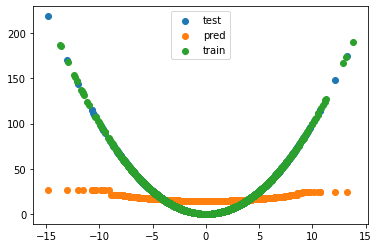

In [516]:
plt.scatter(X_test, y_test, label='test')
plt.scatter(X_test, y_pred, label='pred')
plt.scatter(X_train, y_train, label='train')
plt.legend()

In [490]:
n = 2000
X_train = np.random.normal(0, 6, (n, 1))
y_train = X_train[:, 0]**2

X_valid = np.random.normal(0, 6, (n, 1))
y_valid = X_valid[:, 0]**2

X_test = np.random.normal(0, 6, (n, 1))
y_test = X_test[:, 0]**2

In [495]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
]
ridge_pipe = Pipeline(steps)
# ridge_pipe.fit(X['train'], y['train'])
# print_results(ridge_pipe, X['test'], y['test'])

param_grid = {
    'ridge__alpha': [100, 120, 130, 140, 250, 270],
}
grid_search = GridSearchCV(estimator=ridge_pipe, param_grid=param_grid, cv=None, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'ridge__alpha': 100}


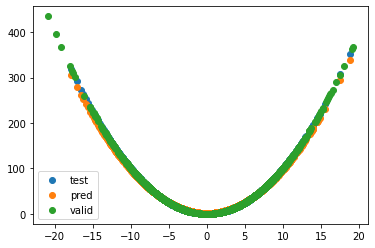

In [496]:
plt.scatter(X_test, y_test, label='test')
plt.scatter(X_test, y_pred, label='pred')
plt.scatter(X_valid, y_valid, label='valid')
plt.legend()

# NN

In [445]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [502]:
import torch
from torch import nn
from torch.utils.data import DataLoader

class TripDataset(torch.utils.data.Dataset):
    '''
    Prepare the Boston dataset for regression
    '''

    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            self.X = torch.from_numpy(X.values)
            self.y = torch.from_numpy(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
      

class Net(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self, n_feature, n_hidden, n_output):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_feature, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 3 * n_hidden),
            nn.ReLU(),
            nn.Linear(3 * n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output),
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

def run_epoch(trainloader, net, optimizer, loss_function):
    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
        # Zero the gradients
        optimizer.zero_grad()
      
        # Perform forward pass
        outputs = net(inputs)
      
        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()
      
        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 10))
            current_loss = 0.0

In [503]:
n = 2000
X_train = np.random.normal(0, 6, (n, 1))
y_train = X_train[:, 0]**2

X_valid = np.random.normal(0, 6, (n, 1))
y_valid = X_valid[:, 0]**2

X_test = np.random.normal(0, 6, (n, 1))
y_test = X_test[:, 0]**2

In [504]:
# Set fixed random number seed
torch.manual_seed(42)

dataset = TripDataset(pd.DataFrame(X_train), pd.Series(y_train))
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)

# Initialize the MLP
net = Net(X_train.shape[1], 16, 1)

# Define the loss function and optimizer
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
    
loss_function = RMSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)
  
# Run the training loop
for epoch in range(5): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    run_epoch(trainloader, net, optimizer, loss_function)

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 3.658
Loss after mini-batch    11: 62.302
Loss after mini-batch    21: 65.858
Loss after mini-batch    31: 50.231
Loss after mini-batch    41: 36.634
Loss after mini-batch    51: 27.732
Loss after mini-batch    61: 17.946
Loss after mini-batch    71: 21.208
Loss after mini-batch    81: 30.966
Loss after mini-batch    91: 24.799
Loss after mini-batch   101: 18.530
Loss after mini-batch   111: 20.746
Loss after mini-batch   121: 23.834
Loss after mini-batch   131: 18.717
Loss after mini-batch   141: 23.532
Loss after mini-batch   151: 17.393
Loss after mini-batch   161: 27.556
Loss after mini-batch   171: 36.291
Loss after mini-batch   181: 15.564
Loss after mini-batch   191: 16.272
Starting epoch 2
Loss after mini-batch     1: 1.571
Loss after mini-batch    11: 12.746
Loss after mini-batch    21: 14.145
Loss after mini-batch    31: 21.606
Loss after mini-batch    41: 17.395
Loss after mini-batch    51: 15.745
Loss after mini-batch    61: 12.

In [505]:
y_pred = net(torch.from_numpy(X_test).float()).detach().numpy().flatten()

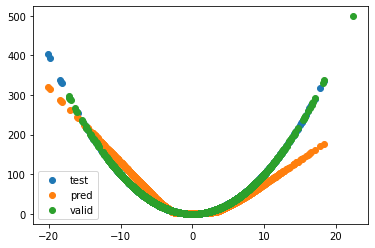

In [506]:
plt.scatter(X_test, y_test, label='test')
plt.scatter(X_test, y_pred, label='pred')
plt.scatter(X_valid, y_valid, label='valid')
plt.legend()